### 데이터 처리
    에스와이코퍼레이션
    
    <ME>
    
    <AGE>

### 모듈 import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import scipy.stats as ss 
import statsmodels.formula.api as smf
import FinanceDataReader as fdr
import pandas_datareader.data as web

### input 설정

In [2]:
### 전체기간
start = '2003-01-02'
end = '2021-08-31'

### VKOSPI 상장일 금융위기 이전
#start = '2003-01-02'
#end = '2007-12-31'

### 금융위기 기간
#start = '2008-01-01'
#end = '2009-12-31'

### 금융위기 이후 ~ 코로나 이전
#start = '2010-01-01'
#end = '2019-12-31'

## 코로나 기간 & 반등 기간
#start = '2020-01-01'
#end = '2021-08-31'

### 코로나 기간
#start = '2020-01-01'
#end = '2020-12-31'

### 반반 자르기
#start = '2003-01-02'
#end = '2009-12-31'

### 반반 자르기
#start = '2010-01-01'
#end = '2021-08-31'

# 수익률 holding period 결정
ret_hold = 2

# 수익률 jump 결정
ret_jump = 1

# new-west max_lag 결정
# For newey, there are several rules of thumb. For example, in Greene's textbook, the maximum lag order of autocorrelation is given as max_lag =int(`=50^(1/4)')
max_lag = 8

# vix look back period 결정
look_back = 25

For newey, there are several rules of thumb. For example, in Greene's textbook, the maximum lag order of autocorrelation is given as
   max_lag =int(`=50^(1/4)')

### 함수 설정 

In [3]:
def data_preprocess(raw) :
    tmp_stk_list = raw.iloc[8].tolist()
    tmp_stk_list[0] = 'Date'

    data = raw.iloc[13:][::-1]
    data.columns = tmp_stk_list
    data.set_index('Date',inplace =True)
    data = data.T.reset_index().drop_duplicates(['index'], keep='first').set_index('index').T
    data.index = pd.to_datetime(data.index)
    
    #data = data[start:end]
    #data = data.fillna(-1).astype(int).replace(-1, np.nan)
    
    return data

In [4]:
# 코스피 기준 break point 생성 & 모든 종목 분위 나누는 함수
def ks_cut(ks_list_, factor) :
    factor_bp = factor[ks_list].apply(lambda x : x.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), axis =1)
    factor_cut = factor.copy()
    factor_cut[factor_bp.columns] = factor_bp
    
    # 행 별로 코스피 기준 break point를 적용하기 위한 임시 함수
    def tmp_cut(x, f = factor, bp = factor_bp) :
        cut_row = pd.cut(x[f.columns],bins = x[factor_bp.columns], labels=list(range(1,11)))
        return cut_row
    
    # 행 별로 코스피 기준 break point 적용해서 분위 나누기
    factor_cut = factor_cut.apply(tmp_cut, axis =1)
    
    return factor_cut

In [5]:
def cal_average_ret_h_ln(ret_df, cut_df, h_day_list, ln_day_list, l_day_list, n_day_list, hn_day_list, num) :

    average_ret_list = []
    average_ret_h_list = []
    average_ret_ln_list = []
    average_ret_l_list = []
    average_ret_n_list = []
    average_ret_hn_list = []
    
    for i in range(1,num+1) :
        average_ret_list.append(ret_df[cut_df == i].mean().mean())
        average_ret_h_list.append(ret_df.loc[h_day_list][cut_df.loc[h_day_list] == i].mean().mean())
        average_ret_ln_list.append(ret_df.loc[ln_day_list][cut_df.loc[ln_day_list] == i].mean().mean())
        average_ret_l_list.append(ret_df.loc[l_day_list][cut_df.loc[l_day_list] == i].mean().mean())
        average_ret_n_list.append(ret_df.loc[n_day_list][cut_df.loc[n_day_list] == i].mean().mean())
        average_ret_hn_list.append(ret_df.loc[hn_day_list][cut_df.loc[hn_day_list] == i].mean().mean())
    
    return average_ret_list, average_ret_h_list, average_ret_ln_list, average_ret_l_list, average_ret_n_list,average_ret_hn_list

In [6]:
def plot_avg_ret_h_n_l(avg_ret, avg_ret_h, avg_ret_ln, avg_ret_l, avg_ret_n, avg_ret_hn, _f_name_):
    
    # 차트 외부 배경색 하얗게
    plt.rc('figure', facecolor = 'w', edgecolor ='w')
    plt.rc('font', size=17)
    # 모든 기간 수익률 평균
    plt.figure(1)
    plt.title('{}_avg_all'.format(_f_name_), pad = 20)
    plt.bar(range(1,len(avg_ret) +1), avg_ret)
    #plt.savefig('C:/Users/USER/OneDrive/바탕화면_백업\논문/데이터작업/result_all/{}_avg_all.png'.format(_f_name_), bbox_inches='tight')

    # VIX 높은 시그널 (투자심리 안좋음) 나온 다음날 수익률 평균
    plt.figure(2)
    plt.title('{}_avg_h'.format(_f_name_), pad = 20)
    plt.bar(range(1,len(avg_ret_h) +1), avg_ret_h)
    #plt.savefig('C:/Users/USER/OneDrive/바탕화면_백업\논문/데이터작업/result_h/{}_avg_h.png'.format(_f_name_), bbox_inches='tight')

    # VIX 낮거나 평범한 나온 다음날 수익률 평균
    plt.figure(3)
    plt.title('{}_avg_ln'.format(_f_name_), pad = 20)
    plt.bar(range(1,len(avg_ret_ln) +1), avg_ret_ln)
    #plt.savefig('C:/Users/USER/OneDrive/바탕화면_백업\논문/데이터작업/result_ln/{}_avg_ln.png'.format(_f_name_), bbox_inches='tight')

    # VIX 낮은 시그널 (투자심리 좋음) 나온 다음날 수익률 평균
    plt.figure(4)
    plt.title('{}_avg_l'.format(_f_name_), pad = 20)
    plt.bar(range(1,len(avg_ret_l) +1), avg_ret_l)
    #plt.savefig('C:/Users/USER/OneDrive/바탕화면_백업\논문/데이터작업/result_l/{}_avg_l.png'.format(_f_name_), bbox_inches='tight')

    # VIX 보통인 다음날 수익률 평균
    plt.figure(5)
    plt.title('{}_avg_n'.format(_f_name_), pad = 20)
    plt.bar(range(1,len(avg_ret_n) +1), avg_ret_n)
    #plt.savefig('age_average_n.png')

    # VIX 높거나 평범한 나온 다음날 수익률 평균
    plt.figure(6)
    plt.title('{}_avg_hn'.format(_f_name_), pad = 20)
    plt.bar(range(1,len(avg_ret_hn) +1), avg_ret_hn)
    #plt.savefig('C:/Users/USER/OneDrive/바탕화면_백업\논문/데이터작업/result_hn/{}_avg_hn.png'.format(_f_name_), bbox_inches='tight')

In [7]:
def cal_ret_h_ln(ret_df, cut_df, num) :

    ret_1_list = ret_df[cut_df == 1].mean(axis=1).iloc[1:]
    ret_10_list = ret_df[cut_df == 10].mean(axis=1).iloc[1:]

    return ret_1_list,ret_10_list

In [8]:
def stat(df, ret_hold_) :

    avg_    = float(df.mean() / ret_hold_)
    std_    = float(df.std() / ret_hold_)
    skew_   = float(df.skew() / ret_hold_)
    
    an_avg_    = (avg_ * 252 ) * 100
    an_std_    = ( std_ * np.sqrt(252) ) * 100
    an_skew_   = skew_ * 100
                    
    stat_df_ = pd.DataFrame()
    stat_df_['avg_ret'] = [an_avg_]
    stat_df_['std_'] = [an_std_]
    stat_df_['skew_'] = [skew_]
    stat_df_['sratio_'] = [an_avg_/an_std_]

    return stat_df_

### 경로 설정

In [9]:
# reset path
main_path = 'C:/Users/USER/OneDrive/바탕화면_백업/논문/데이터작업/'
os.chdir(main_path)

### 코스피 종목 선정

In [10]:
ks_list = pd.read_csv('ks_list.csv').iloc[5:, 1].tolist()

# 기존 종목 리스트에 없는 종목 제거 (스팩주, 신규상장주 등)
ks_list = list(set(ks_list) - set(['동양밸류스팩', '엔에이치스팩19호', '시몬느액세서리컬렉션',
                '현대중공업', '우리스팩1호', '케이카', '대우증권스팩', '카카오페이',]))

### Close & Return 전처리

In [11]:
close = pd.read_csv('close.csv')
close = data_preprocess(close)
close = close.fillna(-1).astype('int64').replace(-1, np.nan)

close = close.drop(['에이치앤비디자인', '얍엑스'],axis=1)

stk_filter_spc = close.columns.map(lambda x: np.nan if '스팩' in x else x).dropna()
close = close[stk_filter_spc]

### 정리 매매 기간 30% 가격등락폭 제외되지 않을 때 급등하는 종목 데이터 제외
# [극단치] (2013년 9월 11일) 에스와이코퍼레이션 하루만에 약 670만% 상승 & 그 이전에도 너무 작은 주가-> 결측치 처리
# [극단치] (2013년 2001-01-02) UC아이콜스 주가조작사건 -> 결측치 처리

### 동전주 제거
close = close[close > 1000]

# 다른 통계치 계산용 변수 정의
close_me = close.loc['2001-01-02':]
close_sig = close.loc['2001-01-02':]
close_sg = close.loc['2001-01-02':]
close = close[start:end]

# 수익률 주기 결정
### -30% ~ 30% 제한폭 넘는 데이터 제거 
ret = close.pct_change(periods = 1)
ret = ret.sort_index(axis=1)
ret = ret[ret < 0.31]
ret = ret[ret > -0.31]

# input: ret_hold 삽입
if ret_hold != 1 : 
    ret = close[ret.notnull()].pct_change(ret_hold).shift(-(ret_hold-1))
    
# input: ret_jump 삽입
ret = ret.shift(-ret_jump +1)

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,25

### Vkospi 관련 데이터 전처리

In [12]:
vkospi = pd.read_csv('vkospi.csv').iloc[13:,:-1][::-1]
vkospi.columns = ['Date', 'vkospi']
vkospi.set_index('Date',inplace = True)
vkospi = vkospi[start:end]

######### input: look_back 삽입 ############
vkospi_mean_tmp = vkospi.rolling(look_back).mean().dropna()
vkospi_t_1 = vkospi.loc[vkospi_mean_tmp.index].dropna().astype(float).iloc[1:]

vkospi_mean = vkospi_mean_tmp.copy()
vkospi_mean = vkospi_mean.astype(float)

vkospi_mean_10 = vkospi_mean + vkospi_mean * 0.1
vkospi_mean_10 = vkospi_mean_10.shift(1).iloc[1:]

# ex)
# 2003/3/13: t-1시점
# 2003/3/14: t시점

# t-1 시점에 VIX가 t-26에서 t-2 사이 평균 VIX 보다 최소 10% 높을 때
# vix_0_1: !!! t시점임  !!!
# 1: high vix, 0: low or normal vix 
vix_0_1 = (vkospi_t_1 > vkospi_mean_10).astype(float)
vix_0_1 = vix_0_1.shift(1).iloc[1:]

h_day = vix_0_1[vix_0_1['vkospi'] == 1].index.tolist()
l_n_day = vix_0_1[vix_0_1['vkospi'] == 0].index.tolist()


print('VIX High day 갯수:',len(h_day))
print('VIX Low & Normal day 갯수:',len(l_n_day))

# t-1 시점 VIX가 t-26에서 t-2 사이 평균 VIX 보다 최소 10% 낮을 때
# 1: low vix, 0: high or normal vix 
vkospi_mean_10_n = vkospi_mean - vkospi_mean * 0.1
vkospi_mean_10_n = vkospi_mean_10_n.shift(1).iloc[1:]

vix_0_1_n = (vkospi_t_1 < vkospi_mean_10_n).astype(float)
vix_0_1_n = vix_0_1_n.shift(1).iloc[1:]

l_day = vix_0_1_n[vix_0_1_n['vkospi'] == 1].index.tolist()
h_n_day = vix_0_1_n[vix_0_1_n['vkospi'] == 0].index.tolist()

n_day = sorted(list(set(l_n_day) - set(l_day)))

print('VIX Low day 갯수:',len(l_day))
print('VIX High & Normal day 갯수:',len(h_n_day))
print('VIX Normal day 갯수:',len(n_day))

date_list = vkospi.index.tolist()

vkospi_z =ss.zscore(vkospi_t_1).flatten().tolist()

v_z_df_origin = vkospi_t_1.copy()
v_z_df_origin['vkospi'] = vkospi_z

v_z_df = vkospi_t_1.copy()
v_z_df['vkospi_l'] = v_z_df_origin[v_z_df_origin['vkospi'] < -0.5]
v_z_df['vkospi_h'] = v_z_df_origin[v_z_df_origin['vkospi'] > 0.5]
v_z_df.columns = ['v', 'l', 'h']
v_z_df.index = pd.to_datetime(v_z_df.index)
v_z_df = v_z_df.shift(1).iloc[1:]

print('----------------------------------')
print('VIX HIGH DAY', len(v_z_df['h'].dropna().index))
print('VIX LOW DAY', len(v_z_df['l'].dropna().index))


VIX High day 갯수: 729
VIX Low & Normal day 갯수: 3864
VIX Low day 갯수: 876
VIX High & Normal day 갯수: 3717
VIX Normal day 갯수: 2988
----------------------------------
VIX HIGH DAY 951
VIX LOW DAY 1625


### ME 계산 위한 데이터 전처리

In [13]:
close_me_m = close_me['2001-06':].assign(Date = close_me['2001-06':].index).resample('M').last().set_index('Date')
close_me_6m = close_me_m[close_me_m.index.month == 6]

me = pd.read_csv('me2.csv')
me = data_preprocess(me).iloc[1:]
me = me.astype(float)
me = me * 1000000

me_6m = me[me.index.month == 6]
me_6m = me_6m.iloc[1:]
me_6m.index = close_me_6m.index

me_12m = me[me.index.month == 12]
me_12m = me_12m.iloc[1:]

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

In [14]:
me_nan = close_me.applymap(lambda x : np.nan)

for date in me_6m.index.tolist() :
    me_nan.loc[date] = me_6m.loc[date]

me = me_nan.ffill().loc[start:end]

In [15]:
me_remove = me.applymap(lambda x: x > 10000000000)

### ME 분위별 그래프

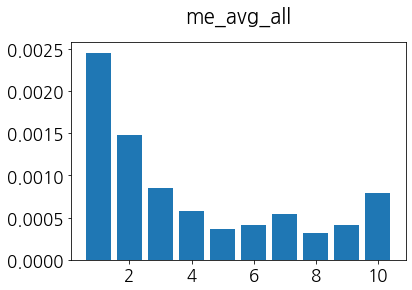

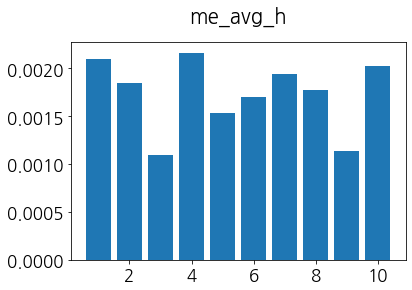

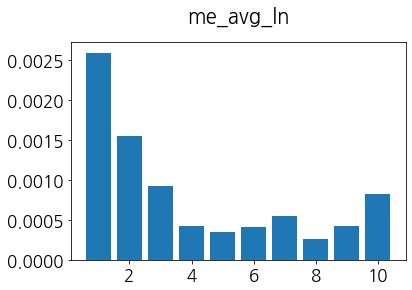

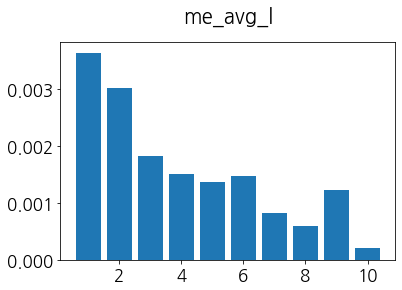

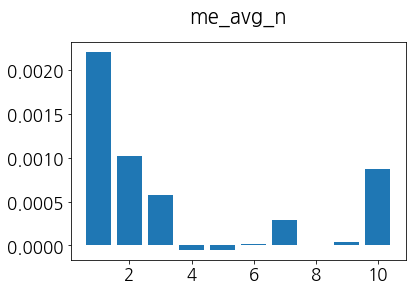

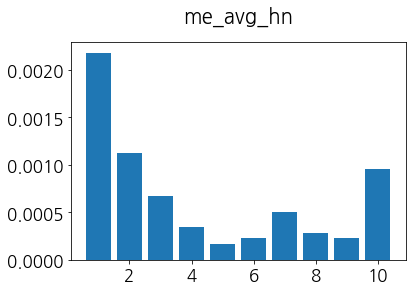

In [16]:
me = me[me_remove]

me_cut = ks_cut(ks_list, me)

# 추가
# - 코스피 breakpoint기준으로 코스피, 코스닥 모두 적용

me_average_ret, me_average_ret_h,me_average_ret_ln, me_average_ret_l, me_average_ret_n, me_average_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                             me_cut,
                                                                                             h_day,
                                                                                             l_n_day,
                                                                                             l_day,
                                                                                             n_day,
                                                                                             h_n_day,
                                                                                             10)

plot_avg_ret_h_n_l(me_average_ret, me_average_ret_h,me_average_ret_ln, me_average_ret_l, me_average_ret_n, me_average_ret_hn, 'me')

### Age 관련 데이터 전처리

In [17]:
age = pd.read_excel('age.xlsx').iloc[5:]
age.columns = ['ticker', 'name', 'reg', 'delist']
age = age.drop_duplicates(['name'], keep='first')
age.set_index('name', inplace = True)
age = age.loc[stk_filter_spc].reset_index()
age.columns = ['name', 'ticker', 'reg', 'delist']

age['delist'] = age['delist'].fillna(9999)
age['reg'] = age['reg'].map(lambda x: datetime.strptime(str(x), '%Y%m%d'))
age['delist'] = age['delist'].map(lambda x: datetime.strptime(str(x), '%Y%m%d').date() if x != 9999 else x)

age_reg = pd.DataFrame()
age_reg['Date'] = date_list
age_reg['Date'] = pd.to_datetime(age_reg['Date'])
age_reg.set_index('Date',inplace=True)

for name, reg in zip(age.name.tolist(), age.reg.tolist()) :
    age_reg[name] = reg.to_period('M')

age.set_index('name',inplace = True)

age_reg_normal = age_reg[age[age['delist'] == 9999].index.tolist()]
age_reg_normal.index = age_reg_normal.index.to_period('M')

age_reg_n_diff = pd.DataFrame()
age_reg_n_diff['Date'] = date_list
age_reg_n_diff.set_index('Date', inplace = True)

for name in age_reg_normal.columns.tolist() :
    age_reg_n_diff[name] = (age_reg_normal.index.astype(int) - age_reg_normal[name].astype(int)).tolist()

age_reg_delist = age_reg[age[age['delist'] != 9999].index.tolist()]
age_reg_delist.index = age_reg_delist.index.to_period('M')

# <상장폐지 종목 날짜 연산 처리>

# if t 시점 날짜 < 상장폐지일 :
# -> t 시점 날짜 - 상장일

# else :
# -> 상장폐지일 - 상장일

age_reg_d_diff = pd.DataFrame()
age_reg_d_diff['Date'] = date_list
age_reg_d_diff.set_index('Date', inplace = True)

for name in age_reg_delist.columns.tolist() :
    age_reg_d_diff[name] = (age_reg_delist.index.astype(int) - age_reg_delist[name].astype(int)).tolist()

for name in age[age['delist'] != 9999].index.tolist() :
    delist_date = age.loc[name]['delist']
    if delist_date <= datetime.strptime(end, "%Y-%m-%d").date() :
        delist_date_str = datetime.strftime(delist_date, "%Y-%m-%d")
        age_reg_d_diff[name].loc[delist_date_str: ] = np.nan

age_final = pd.concat([age_reg_n_diff,age_reg_d_diff], axis =1)
age_final = age_final.applymap(lambda x: np.nan if x < 0 else x)
age_final.index = pd.to_datetime(age_final.index)

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Age 분위별 그래프 

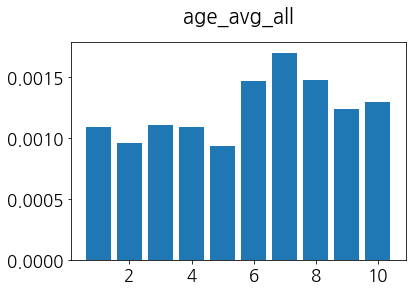

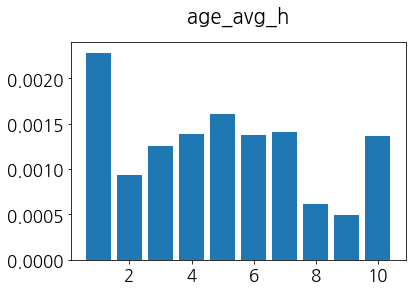

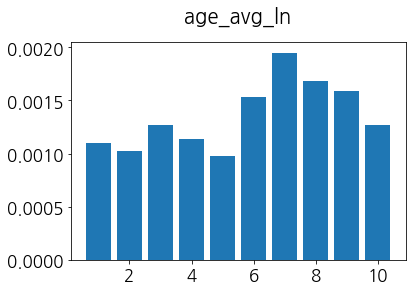

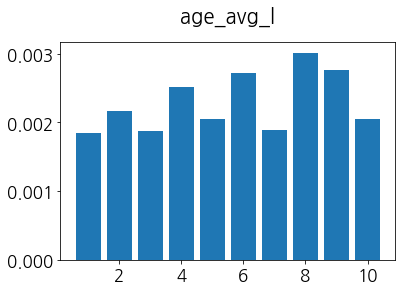

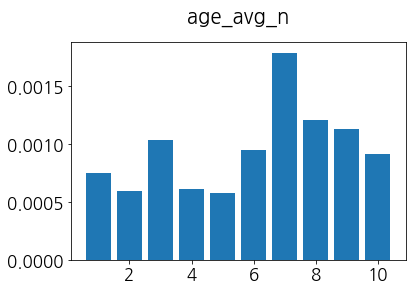

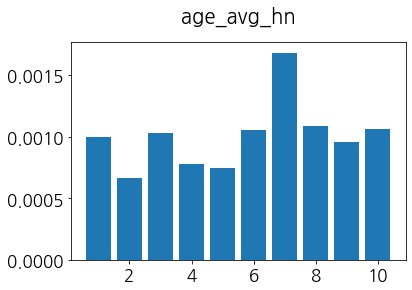

In [18]:
age_final = age_final[me_remove]

age_cut = ks_cut(ks_list, age_final)

age_average_ret, age_average_ret_h,age_average_ret_ln,age_average_ret_l,age_average_ret_n, age_average_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                age_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(age_average_ret, age_average_ret_h,age_average_ret_ln,age_average_ret_l,age_average_ret_n, age_average_ret_hn, 'age')

### Sigma 데이터 전처리

In [19]:
sig = close_sig.copy()

sig_m = sig['2001-05':].assign(Date = sig['2001-05':].index).resample('M').last().set_index('Date').pct_change().iloc[1:]
sig_m = sig_m.rolling(12).std()

sig_6m = sig_m[sig_m.index.month == 6].applymap(lambda x: np.nan if x == 0 else x)

sig_nan = sig.applymap(lambda x : np.nan)

for date in sig_6m.index.tolist() :
    sig_nan.loc[date] = sig_6m.loc[date]

sig = sig_nan.ffill().loc[start:end]


### Sigma 분위별 그래프

In [20]:
# 시가총액 100억원 이하 제외 처리
sig = sig[me_remove]

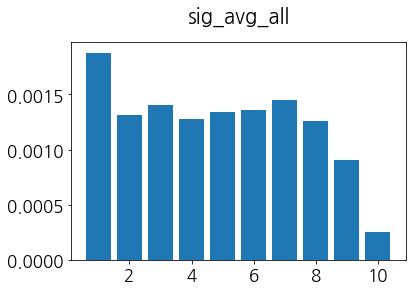

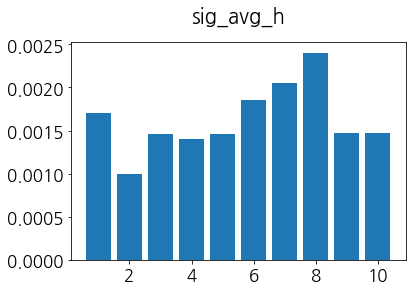

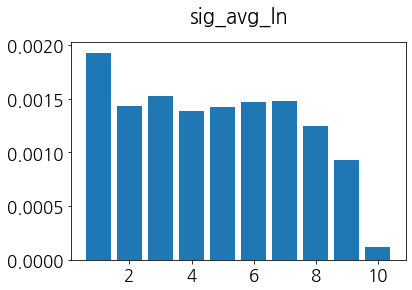

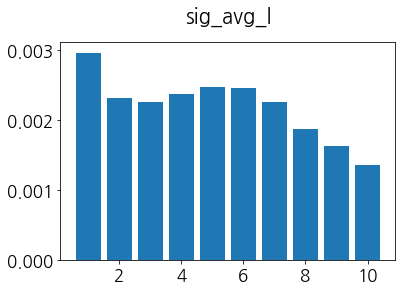

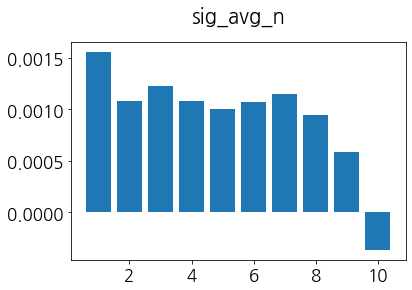

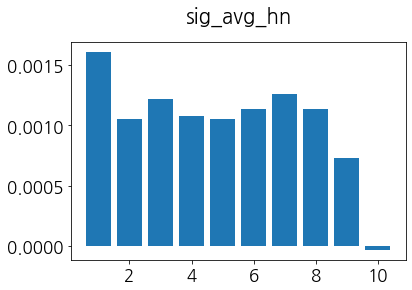

In [21]:
sig_cut = ks_cut(ks_list, sig)

sig_avg_ret, sig_avg_ret_h, sig_avg_ret_ln, sig_avg_ret_l, sig_avg_ret_n, sig_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                sig_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(sig_avg_ret, sig_avg_ret_h, sig_avg_ret_ln, sig_avg_ret_l, sig_avg_ret_n, sig_avg_ret_hn, 'sig')


### Sales growth 데이터 전처리

In [22]:
sg = pd.read_csv('sales.csv')
sg = data_preprocess(sg)
sg = sg.fillna(-1).astype('int64').replace(-1, np.nan)
sg = sg.pct_change()['2002':'2020']

sg_date = close_sg['2002':'2020'].assign(Date = close_sg['2002':'2020'].index).resample('Y').last().set_index('Date').index

sg.index = sg_date
sg_nan = close_sg.applymap(lambda x: np.nan)

for date in sg.index.tolist() :
    sg_nan.loc[date] = sg.loc[date]

sg = sg_nan.ffill().loc[start:end]
sg = sg.applymap(lambda x: np.nan if x == 0 else x)

In [23]:
# 시가총액 100억원 이하 제외 처리
sg = sg[me_remove]

### Sales Growth 분위별 그래프

C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


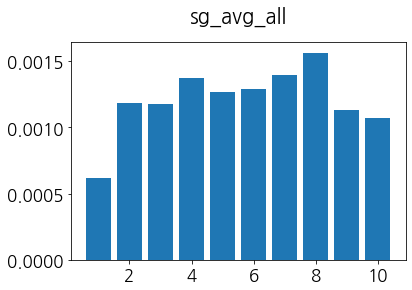

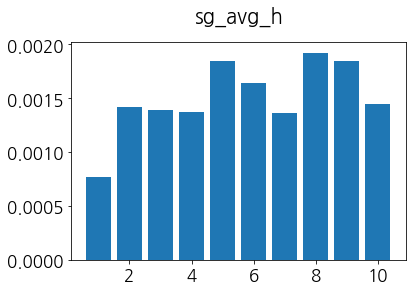

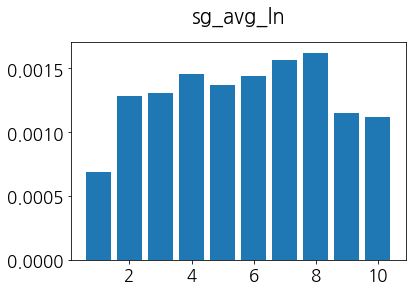

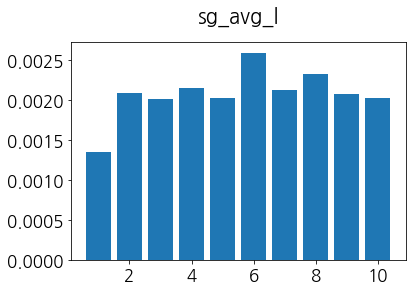

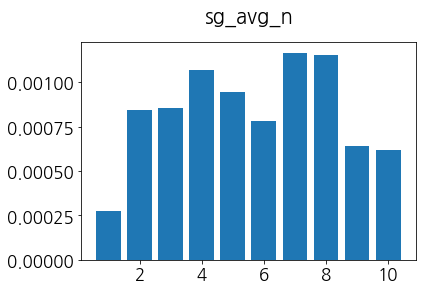

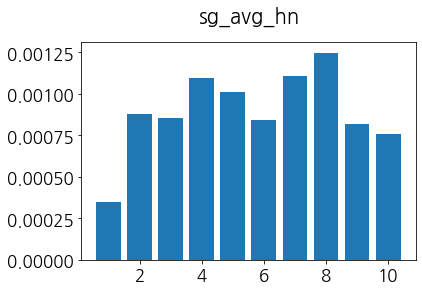

In [24]:
sg_cut = ks_cut(ks_list, sg)

sg_avg_ret, sg_avg_ret_h, sg_avg_ret_ln, sg_avg_ret_l, sg_avg_ret_n, sg_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                sg_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(sg_avg_ret, sg_avg_ret_h, sg_avg_ret_ln, sg_avg_ret_l, sg_avg_ret_n, sg_avg_ret_hn, 'sg')

### BM 계산을 위한 전처리

In [25]:
be = pd.read_csv('be.csv')
be = data_preprocess(be)
be = be.fillna(-1).astype('int64').replace(-1, np.nan)
be = be['2001':'2021']
be.index = sig_6m['2001':'2021'].index

tmp_be = be.copy()
tmp_be = tmp_be.iloc[:-1]
tmp_be.index = sig_6m['2002':'2021'].index

me_12m.index = sig_6m['2002':'2021'].index

bm_12m = tmp_be / me_12m
bm_nan = sig_nan.applymap(lambda x : np.nan)

for date in bm_12m.index.tolist() :
    bm_nan.loc[date] = bm_12m.loc[date]

bm = bm_nan.ffill().loc[start:end]
bm = bm.applymap(lambda x: np.nan if x == 0 else x)

# 시가총액 100억원 이하 제외 처리
bm = bm[me_remove]

### BM 분위별 그래프

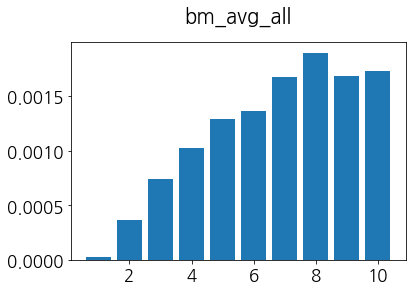

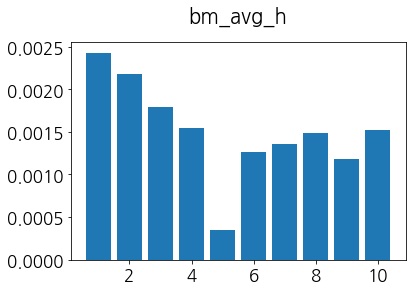

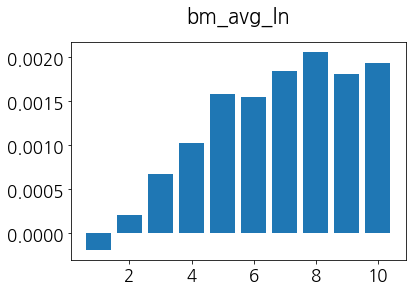

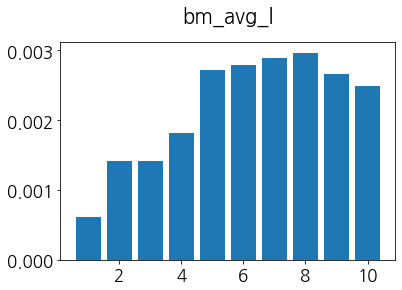

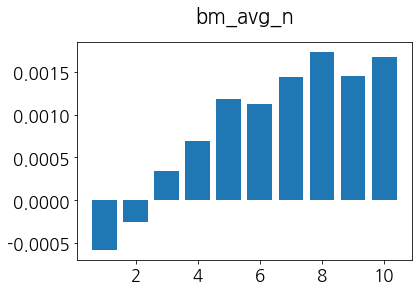

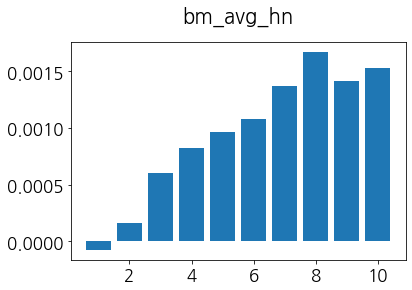

In [26]:
bm_cut = ks_cut(ks_list, bm)

bm_avg_ret, bm_avg_ret_h, bm_avg_ret_ln, bm_avg_ret_l, bm_avg_ret_n, bm_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                bm_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(bm_avg_ret, bm_avg_ret_h, bm_avg_ret_ln, bm_avg_ret_l, bm_avg_ret_n, bm_avg_ret_hn, 'bm')

### Fix asset ratio 데이터 전처리

In [27]:
fa_12m = pd.read_csv('fa.csv')
fa_12m = data_preprocess(fa_12m)
fa_12m = fa_12m.applymap(lambda x: float(x[:-1]) if type(x) == str else x)
fa_12m = fa_12m.fillna(-1).astype('int64').replace(-1, np.nan)
fa_12m = fa_12m['2001':'2021']
fa_12m.index = sig_6m['2001':'2021'].index
fa_12m = fa_12m.shift(1).iloc[1:]

fa_nan = sig_nan.applymap(lambda x : np.nan)

for date in fa_12m.index.tolist() :
    fa_nan.loc[date] = fa_12m.loc[date]

fa = fa_nan.ffill().loc[start:end]
fa = fa.applymap(lambda x: np.nan if x == 0 else x)

### FA 분위별 그래프

In [28]:
# 시가총액 100억원 이하 제외 처리
fa = fa[me_remove]

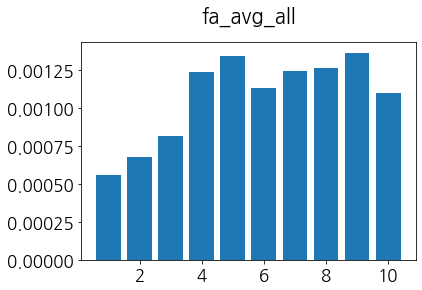

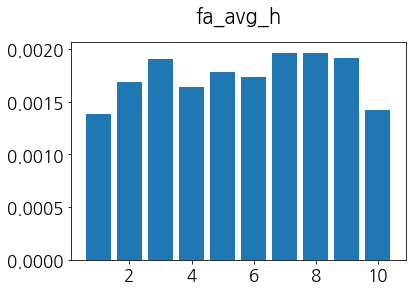

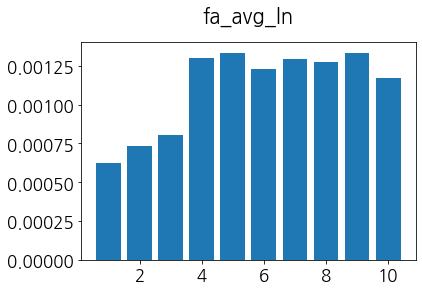

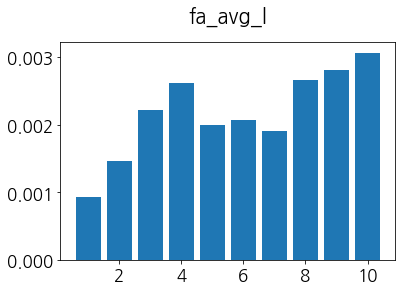

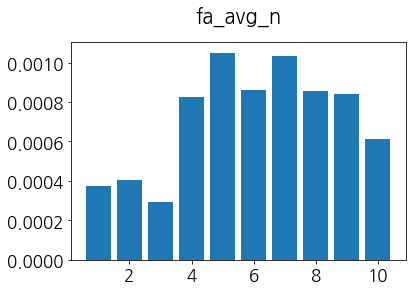

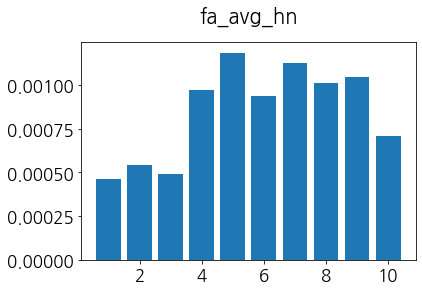

In [29]:
fa_cut = ks_cut(ks_list, fa)

fa_avg_ret, fa_avg_ret_h, fa_avg_ret_ln, fa_avg_ret_l, fa_avg_ret_n, fa_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                fa_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(fa_avg_ret, fa_avg_ret_h, fa_avg_ret_ln, fa_avg_ret_l, fa_avg_ret_n, fa_avg_ret_hn, 'fa')

### Research and Development ratio 데이터 전처리

In [30]:
rd_12m = pd.read_csv('rd.csv')
rd_12m = data_preprocess(rd_12m)
rd_12m = rd_12m.fillna(-1).astype('int64').replace(-1, np.nan)
rd_12m = rd_12m['2001':'2021']
rd_12m.index = sig_6m['2001':'2021'].index

asset_12m = pd.read_csv('asset.csv')
asset_12m = data_preprocess(asset_12m)
asset_12m = asset_12m.fillna(-1).astype('int64').replace(-1, np.nan)
asset_12m_ver2 = asset_12m.copy()
asset_12m = asset_12m['2001':'2021']
asset_12m.index = sig_6m['2001':'2021'].index

ra_12m = rd_12m / asset_12m
ra_12m = ra_12m.shift(1).iloc[1:]
ra_nan = sig_nan.applymap(lambda x : np.nan)

for date in ra_12m.index.tolist() :
    ra_nan.loc[date] = ra_12m.loc[date]

ra = ra_nan.ffill().loc[start:end]
ra = ra.applymap(lambda x: np.nan if x == 0 else x)

<ipython-input-30-16aefcfdc71b>:11: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  asset_12m = asset_12m['2001':'2021']


### RA 분위별 그래프

In [31]:
# 시가총액 100억원 이하 제외 처리
ra = ra[me_remove]

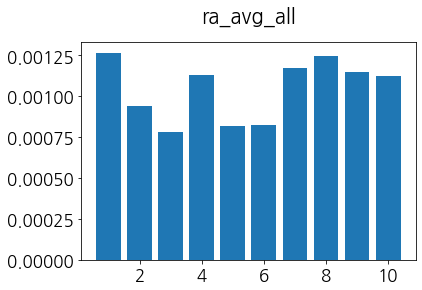

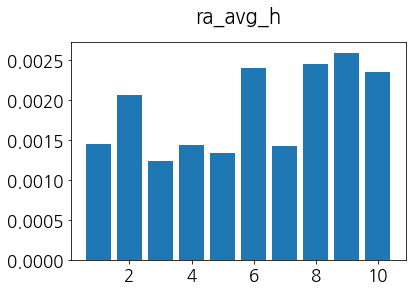

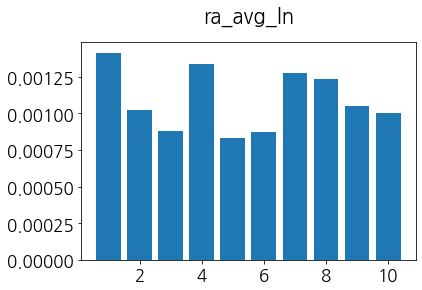

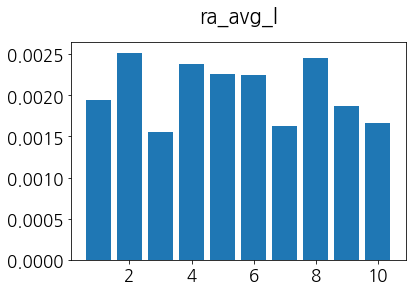

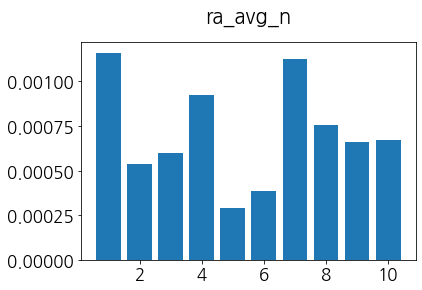

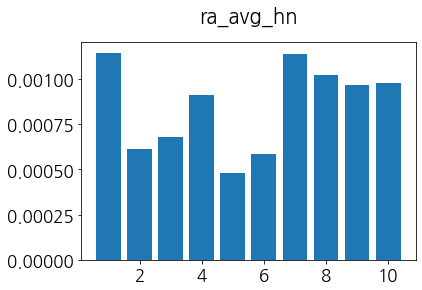

In [32]:
ra_cut = ks_cut(ks_list, ra)

ra_avg_ret, ra_avg_ret_h, ra_avg_ret_ln, ra_avg_ret_l, ra_avg_ret_n, ra_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                ra_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(ra_avg_ret, ra_avg_ret_h, ra_avg_ret_ln, ra_avg_ret_l, ra_avg_ret_n, ra_avg_ret_hn, 'ra')

### DB 데이터 전처리

In [33]:
div_12m = pd.read_csv('div.csv')
div_12m = data_preprocess(div_12m)
div_12m = div_12m.fillna(-1).astype('int64').replace(-1, np.nan)
div_12m = div_12m['2001':'2021']
div_12m.index = sig_6m['2001':'2021'].index

db_12m = (div_12m / be).shift(1).iloc[1:]

# 0보다 작을 경우 0으로 처리
db_12m[db_12m < 0] = 0

db_nan = sig_nan.applymap(lambda x : np.nan)

for date in db_12m.index.tolist() :
    db_nan.loc[date] = db_12m.loc[date]

db = db_nan.ffill().loc[start:end]
db = db.applymap(lambda x: np.nan if x == 0 else x)

# 시가총액 100억원 이하 제외 처리
db = db[me_remove]

<ipython-input-33-9a5ad3c13145>:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  div_12m = div_12m['2001':'2021']


### DB 분위별 그래프

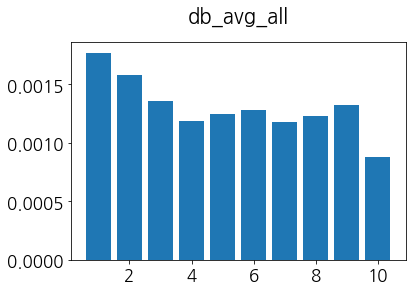

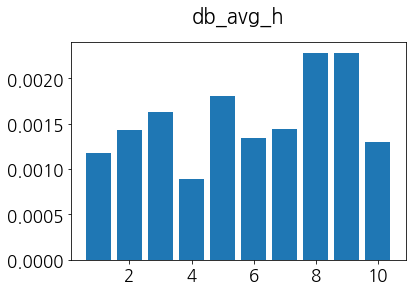

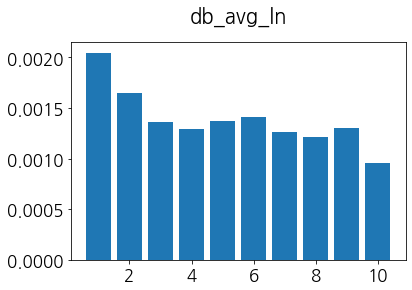

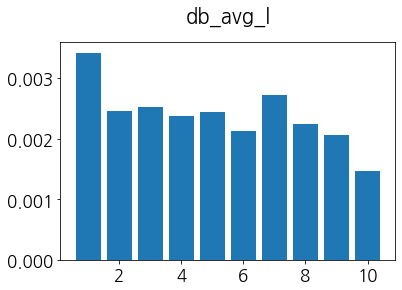

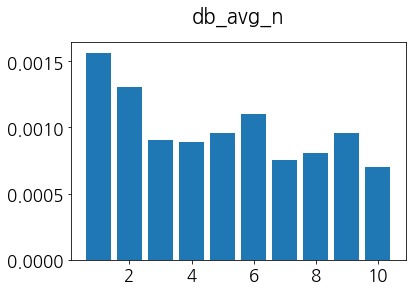

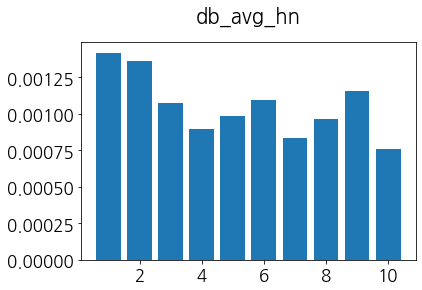

In [34]:
db_cut = ks_cut(ks_list, db)

db_avg_ret, db_avg_ret_h, db_avg_ret_ln, db_avg_ret_l, db_avg_ret_n, db_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                db_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(db_avg_ret, db_avg_ret_h, db_avg_ret_ln, db_avg_ret_l, db_avg_ret_n, db_avg_ret_hn, 'db')

### REA 데이터 전처리

In [35]:
re_12m = pd.read_csv('re.csv')
re_12m = data_preprocess(re_12m)
re_12m = re_12m.fillna(-1).astype('int64').replace(-1, np.nan)
re_12m = re_12m['2000':'2021']

asset_12m_ver3 = asset_12m_ver2.copy()
asset_12m_ver3 = asset_12m_ver3.iloc[1:]
asset_12m_diff = asset_12m_ver3.diff().iloc[1:]

re_12m_diff = re_12m.diff().iloc[1:]

rea_12m = (asset_12m_diff - re_12m_diff) / asset_12m_ver2
rea_12m = rea_12m.shift(1).iloc[3:]

rea_12m.index = sig_6m['2002':'2021'].index
rea_nan = sig_nan.applymap(lambda x : np.nan)

for date in rea_12m.index.tolist() :
    rea_nan.loc[date] = rea_12m.loc[date]

rea = rea_nan.ffill().loc[start:end]
rea = rea.applymap(lambda x: np.nan if x == 0 else x)

# 시가총액 100억원 이하 제외 처리
rea = rea[me_remove]

<ipython-input-35-a4510db5e269>:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  re_12m = re_12m['2000':'2021']


### REA 분위별 그래프

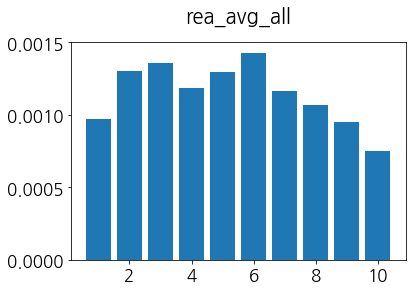

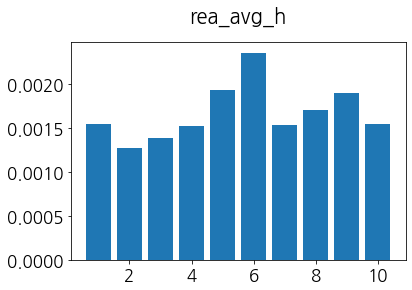

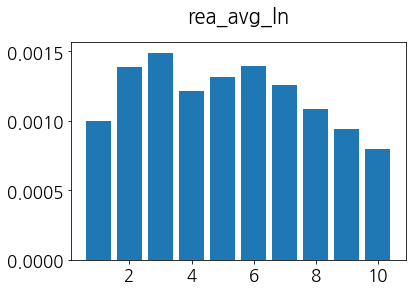

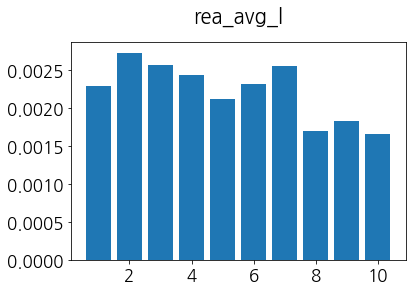

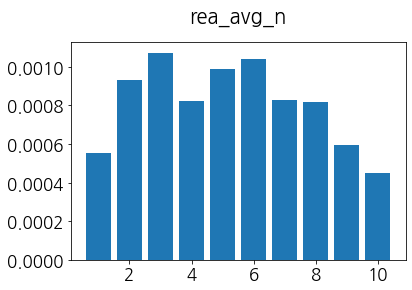

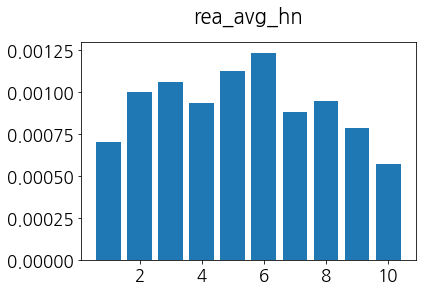

In [36]:
rea_cut = ks_cut(ks_list, rea)

rea_avg_ret, rea_avg_ret_h, rea_avg_ret_ln, rea_avg_ret_l, rea_avg_ret_n, rea_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                rea_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(rea_avg_ret, rea_avg_ret_h, rea_avg_ret_ln, rea_avg_ret_l,
                   rea_avg_ret_n, rea_avg_ret_hn, 'rea')

### EB 데이터 전처리

In [37]:
### 영업이익
# 종목명 맞추기
ee_tmp = pd.read_csv('비영업손익.csv')
ee_12m = pd.read_csv('영업이익.csv')
ee_12m.iloc[8,:] = ee_tmp.iloc[8].tolist()
ee_12m = data_preprocess(ee_12m)
ee_12m = ee_12m.fillna(-1).astype('int64').replace(-1, np.nan)
ee_12m = ee_12m['2001':'2021']
ee_12m.index = sig_6m['2001':'2021'].index

ee_ex_12m = pd.read_csv('비영업손익.csv')
ee_ex_12m = data_preprocess(ee_ex_12m)
ee_ex_12m = ee_ex_12m.fillna(-1).astype('int64').replace(-1, np.nan)
ee_ex_12m = ee_ex_12m['2001':'2021']
ee_ex_12m.index = sig_6m['2001':'2021'].index

de_asset_12m = pd.read_csv('이연법인세자산.csv')
de_asset_12m = data_preprocess(de_asset_12m)
de_asset_12m = de_asset_12m.fillna(-1).astype('int64').replace(-1, np.nan)
de_asset_12m = de_asset_12m['2001':'2021']
de_asset_12m.index = sig_6m['2001':'2021'].index

de_liab_12m = pd.read_csv('이연법인세부채.csv')
de_liab_12m = data_preprocess(de_liab_12m)
de_liab_12m = de_liab_12m.fillna(-1).astype('int64').replace(-1, np.nan)
de_liab_12m = de_liab_12m['2001':'2021']
de_liab_12m.index = sig_6m['2001':'2021'].index

pre_div_12m = pd.read_csv('우선주배당금.csv')
pre_div_12m = data_preprocess(pre_div_12m)
pre_div_12m = pre_div_12m.fillna(-1).astype('int64').replace(-1, np.nan)
pre_div_12m = pre_div_12m['2001':'2021']
pre_div_12m.index = sig_6m['2001':'2021'].index
pre_div_12m = pre_div_12m.fillna(0)

<ipython-input-37-7b60aedfe6b5>:20: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  de_asset_12m = de_asset_12m['2001':'2021']
<ipython-input-37-7b60aedfe6b5>:26: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  de_liab_12m = de_liab_12m['2001':'2021']
<ipython-input-37-7b60aedfe6b5>:32: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  pre_div_12m = pre_div_12m['2001':'2021']


In [38]:
eb_12m = (ee_12m - ee_ex_12m + de_asset_12m - de_liab_12m - pre_div_12m) / be
eb_12m = eb_12m.shift(1).iloc[1:]

eb_nan = sig_nan.applymap(lambda x : np.nan)

for date in eb_12m.index.tolist() :
    eb_nan.loc[date] = eb_12m.loc[date]

eb = eb_nan.ffill().loc[start:end]
eb = eb.applymap(lambda x: np.nan if x == 0 else x)
eb = eb[me_remove]

### EB 분위별 그래프

In [39]:
# 코스피 기준 break point 생성 & 모든 종목 분위 나누는 함수
def ks_cut(ks_list_, factor) :
    factor_bp = factor[ks_list].apply(lambda x : x.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]), axis =1)
    factor_cut = factor.copy()
    factor_cut[factor_bp.columns] = factor_bp

    
    # 행 별로 코스피 기준 break point를 적용하기 위한 임시 함수
    def tmp_cut(x, f = factor, bp = factor_bp) :
        cut_row = pd.cut(x[f.columns],bins = x[factor_bp.columns], labels=list(range(1,11)))
        return cut_row
    
    # 행 별로 코스피 기준 break point 적용해서 분위 나누기
    factor_cut = factor_cut.apply(tmp_cut, axis =1)
    
    return factor_cut

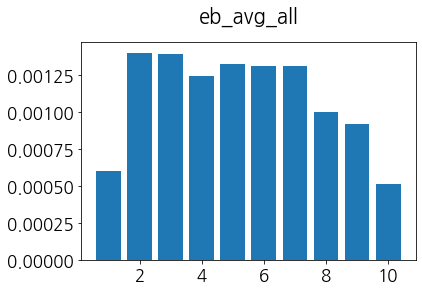

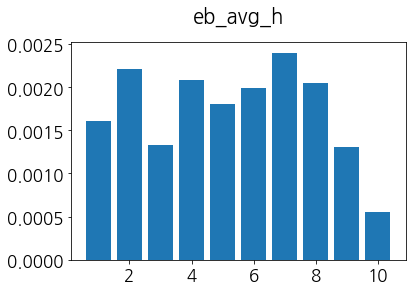

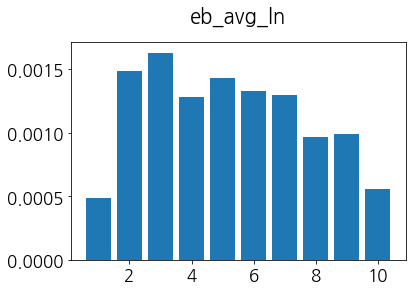

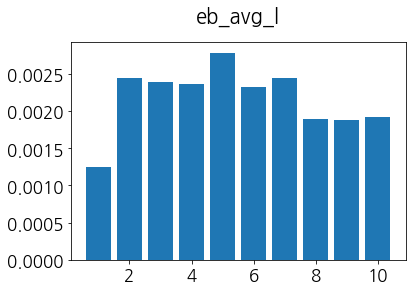

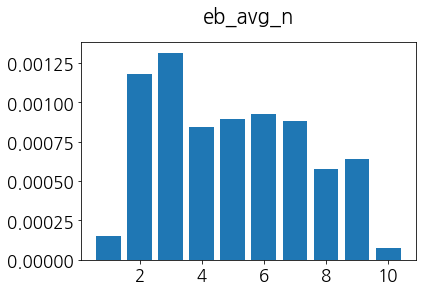

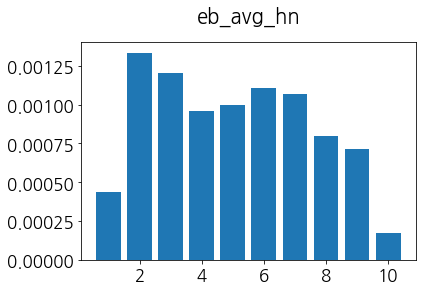

In [40]:
eb_cut = ks_cut(ks_list, eb)

eb_avg_ret, eb_avg_ret_h, eb_avg_ret_ln, eb_avg_ret_l, eb_avg_ret_n, eb_avg_ret_hn =  cal_average_ret_h_ln(ret,
                                                                                                eb_cut,
                                                                                                h_day,
                                                                                                l_n_day,
                                                                                                l_day,
                                                                                                n_day,
                                                                                                h_n_day,
                                                                                                10)

plot_avg_ret_h_n_l(eb_avg_ret, eb_avg_ret_h, eb_avg_ret_ln, eb_avg_ret_l,
                   eb_avg_ret_n, eb_avg_ret_hn, 'eb')

### 파마프렌치 + 모멘텀 데이터 전처리

In [41]:
ff5_mom_js = pd.read_csv('ff5_mom_js.csv')
ff5_mom_js['Date'] = pd.to_datetime(ff5_mom_js['Date'])
ff5_mom_js.set_index('Date',inplace=True)

In [42]:
ff3_js = pd.read_csv('ff3_js.csv')
ff3_js['Date'] = pd.to_datetime(ff3_js['Date'])
ff3_js.set_index('Date',inplace=True)
ff3 = ff3_js.copy()

### t_stat 계산

In [43]:
def ff3_mom_reg(f_name, v_z_df_, ff3_mom_, ret_, factor_cut) :
    factor_1_ret, factor_10_ret  = cal_ret_h_ln(ret_,factor_cut, 10)
    
    if (f_name == 'me' or 'age' or 'sg' or 'fa' or 'db' or 'efa' or 'eb') :
        factor_ret = pd.DataFrame()
        factor_ret['P_I'] = (factor_1_ret - factor_10_ret)
        factor_ret['P'] = factor_1_ret
        factor_ret['I'] = factor_10_ret
        
    elif (f_name == 'sig' or 'bm' or 'ra'):
        factor_ret = pd.DataFrame()
        factor_ret['P_I'] = (factor_10_ret - factor_1_ret)
        factor_ret['P'] = factor_10_ret
        factor_ret['I'] = factor_1_ret
        
    def reg(f_name, v_z_df_, ff3_mom_, factor_ret_, kind, period) :
        v_z_df__ = v_z_df_.copy()
        v_z_df__.columns = ['all', 'low', 'high']

        reg_df = pd.DataFrame()
        reg_df[period] =  v_z_df__[period].dropna()
        reg_df[['P_I', 'P', 'I']] = factor_ret_.loc[v_z_df__[period].dropna().index]
        reg_df[['mkt_rf','HML', 'SMB', 'RMW', 'CMA', 'MOM']] = ff3_mom_.loc[v_z_df__[period].dropna().index]
        if (f_name == 'age' or 'sig' or 'sg' or 'fa' or 'ra' or 'db' or 'efa' or 'eb'):
            reg_result = smf.ols('{} ~ 1 + {} + mkt_rf + HML + SMB + RMW + CMA + MOM'.format(kind, period),data=reg_df).fit(cov_type='HAC',
                                                                                               cov_kwds={'maxlags':max_lag}, use_t=True)
        elif f_name == 'me' :
            reg_result = smf.ols('{} ~ 1 + {} + mkt_rf + HML + RMW + CMA + MOM'.format(kind, period),data=reg_df).fit(cov_type='HAC',
                                                                                               cov_kwds={'maxlags':max_lag}, use_t=True)

        elif f_name == 'bm':
            reg_result = smf.ols('{} ~ 1 + {} + mkt_rf + SMB + RMW + CMA + MOM'.format(kind, period),data=reg_df).fit(cov_type='HAC',
                                                                                               cov_kwds={'maxlags':max_lag}, use_t=True)
        else :
            print('잘못된 팩터를 입력하셨습니다.')
        
        return reg_result.params[1], reg_result.tvalues[1]
        
    t_list = []
    beta_list = []
    for period_ in ['all', 'low', 'high'] : 
        for kind_ in ['P_I', 'P', 'I'] : 

            beta, t = reg(f_name, v_z_df_, ff3_mom_, factor_ret, kind_, period_)
            beta_list.append(beta)
            t_list.append(t)


    return beta_list, t_list

In [44]:
f_name_list = ['me', 'age', 'sig', 'eb', 'db', 'fa', 'ra', 'bm', 'efa', 'sg']
f_cut_list = [me_cut, age_cut, sig_cut, eb_cut, db_cut, fa_cut, ra_cut, bm_cut, rea_cut, sg_cut]

final_beta_df = pd.DataFrame()
final_t_df = pd.DataFrame()

for f_name_, f_cut_ in zip(f_name_list, f_cut_list)  :
    final_beta_df[f_name_], final_t_df[f_name_] = ff3_mom_reg(f_name_, v_z_df, ff5_mom_js, ret, f_cut_)

final_beta_df.index = ['PI_all', 'P_all', 'I_all',
                       'PI_low', 'P_low', 'I_low',
                       'PI_high', 'P_high', 'I_high']

final_t_df.index = ['PI_all', 'P_all', 'I_all',
                    'PI_low', 'P_low', 'I_low',
                    'PI_high', 'P_high', 'I_high']


In [45]:
final_beta_df.T * 100

,PI_all,P_all,I_all,PI_low,P_low,I_low,PI_high,P_high,I_high
me,-0.007759,-0.001029,0.006730,0.149502,0.133223,-0.016279,-0.085961,-0.019422,0.066539
age,0.003530,0.007852,0.004322,0.186589,0.057526,-0.129063,0.124597,0.109292,-0.015306
sig,-0.007492,-0.000756,0.006736,-0.146181,-0.037955,0.108226,-0.149207,-0.034689,0.114518
eb,0.000543,0.002392,0.001849,0.025415,0.087274,0.061859,0.003553,0.038816,0.035263
db,-0.000323,0.004566,0.004888,0.126068,0.064860,-0.061208,-0.030206,0.056512,0.086718
fa,-0.001391,0.001791,0.003182,-0.199017,-0.047228,0.151789,0.006128,0.041906,0.035778
ra,-0.003651,0.002691,0.006342,-0.111550,-0.014409,0.097140,-0.087404,0.025148,0.112552
bm,0.004216,0.004694,0.000478,-0.167636,-0.072014,0.095621,0.151081,0.115317,-0.035764
efa,-0.000634,0.002046,0.002680,-0.006685,0.076155,0.082839,0.009033,0.067807,0.058774
sg,-0.005250,0.001504,0.006755,-0.047765,0.069743,0.117507,-0.095991,0.017763,0.113754


In [46]:
final_t_df.T

,PI_all,P_all,I_all,PI_low,P_low,I_low,PI_high,P_high,I_high
me,-1.983881,-0.512615,1.370120,1.096732,1.325922,-0.139500,-0.966329,-0.514296,0.581942
age,1.460909,2.074275,0.923889,1.304701,0.362337,-0.954074,2.438990,1.349240,-0.147906
sig,-1.892314,-0.634255,1.548733,-0.987799,-0.501586,0.719981,-1.766010,-1.580721,1.150204
eb,0.360367,0.856158,0.538842,0.275292,0.829294,0.553735,0.134429,0.661122,0.491141
db,-0.183000,1.207062,1.360326,1.120085,0.485828,-0.522829,-0.904915,0.659987,1.044856
fa,-0.857421,0.512855,0.954825,-2.088161,-0.423446,1.501233,0.208397,0.555366,0.461046
ra,-1.254983,0.620955,1.797935,-0.707400,-0.108197,0.606561,-1.420742,0.253303,1.454049
bm,1.244817,1.238089,0.198052,-1.065936,-0.561162,0.698576,2.384989,1.408306,-0.824742
efa,-0.492383,0.624871,0.743438,-0.077765,0.755267,0.685255,0.405481,0.949088,0.754321
sg,-2.950752,0.452503,1.722709,-0.392490,0.529931,0.716613,-2.424074,0.263290,1.266398


In [47]:
# <Panel A>

# (공통점)
# (1) 7개 중 5개의 롱숏 포트폴리오가 delayed arbitrage 이론과 부합하게 negative관계를 가짐 
# (2) 감정에 민감한 PF가 감정에 둔감한 PF보다 유의성 높게 나옴
# (3) 감정에 둔감한 PF의 경우 ra를 제외하고 유의하지 않게 나옴
# -> 3가지 결과 모두 key paper와 맞아떨어지는 결과

# (차이점)
# (1) key paper에서는 low sentiment시기에 me가 positive로 유의하게 나온 반면, 이 연구에서는 negative하고
# 유의하지 않게 나옴. low sentiment 시기라고 해서 시가총액이 높은 기업으로 자금이 쏠리지 않는다는 걸 의미
# (2) 컬럼3에서 오히려 ra가 positive하게 유의성있게 나옴. 대부분 기간의 경우
# 자산에 비해 연구비를 많이 써서 공격적으로 성장하려는 기업보다 안정적인 기업을 더 선호한다는 것을 의미함. 
# 이는 flight-to-quality로 설명 가능함. Baker and Wurgler(2007)

# <Panel B>
# (공통점)
# (1) high sentiment period에서 더 높은 유의성이 나옴
# -> key paepr와 맞아떨어지는 결과
# (2) 투자자 감정이 좋을 때 감정에 민감한 포트폴리오의 수익률에 대한 예측력이 높아지는 것을 의미함.

# <Panel C>

# (공통점)
# (1) low sentiment period에서는 VIX가 다음날의 감정에 민감&둔감 PF의 수익률에 대해 예측력이 거의 없다는 것을
# 보여준다. Stambaug et al (2012)와 같은 결과

# (차이점)
# (2) me의 경우 positive로 유의하게 나옴. low sentiment일때 오히려 소형주를 선호했다. panel A와는 다른 결과


In [48]:
# 연구비 높은 기업이 감정에 민감함
# 연구비 높은 기업 long + 연구비 낮은 기업 short
# negative corr의 의미는 vix가 낮아질수록 연구비 낮은 기업이 오른다는 것.

### VIX기반 트레이딩 전략

In [49]:
def p_l_ff3_ret(f_name, v_z_df_, ff3_mom_, ret_, factor_cut, h_day_, l_n_day_, ret_hold_) :
    factor_1_ret, factor_10_ret  = cal_ret_h_ln(ret_,factor_cut, 10)
    
    if (f_name == 'me' or 'age' or 'sg' or 'fa' or 'db' or 'efa', 'eb') :
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_1_ret - factor_10_ret)
        factor_ret_df_['P'] = factor_1_ret
        factor_ret_df_['I'] = factor_10_ret
        
    elif (f_name == 'sig' or 'bm' or 'ra'):
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_10_ret - factor_1_ret)
        factor_ret_df_['P'] = factor_10_ret
        factor_ret_df_['I'] = factor_1_ret
    
    bm_pf_ = pd.DataFrame(factor_ret_df_['P_I'])
    
    vix_strgy_df_ = pd.DataFrame(factor_ret_df_['P_I'].copy())
    vix_strgy_df_.loc[:, 'P_I'] = np.nan
    vix_strgy_df_['P_I'].loc[l_n_day_] = factor_ret_df_.loc[l_n_day_, 'P']  
    vix_strgy_df_['P_I'].loc[h_day_] = factor_ret_df_.loc[h_day_, 'I']
    vix_strgy_df_ = vix_strgy_df_.dropna()
    
    bm_pf_ = bm_pf_.loc[vix_strgy_df_.index]
    rvix_df_ = vix_strgy_df_ - bm_pf_
    success_ = sum(rvix_df_['P_I'] > 0) / len(rvix_df_['P_I'])
    
    total_stat_df_ = stat(bm_pf_, ret_hold_)
    total_stat_df_.columns = ['A_avg_ret', 'A_std', 'A_skew', 'A_sratio']
    total_stat_df_[['B_avg_ret', 'B_std', 'B_skew', 'B_sratio']] = stat(vix_strgy_df_, ret_hold_)
    total_stat_df_[['C_avg_ret', 'C_std', 'C_skew', 'C_success']] = stat(rvix_df_, ret_hold_)
    total_stat_df_.index = [f_name]
    
    return total_stat_df_, rvix_df_, success_

In [50]:
# 변경 전
final_stat_df = pd.DataFrame()
success_list = []

for f_name_, f_cut_ in zip(f_name_list, f_cut_list)  :
    total_stat_df, rvix_df, success =  p_l_ff3_ret(f_name_, v_z_df, ff5_mom_js, ret, f_cut_, h_day, l_n_day, ret_hold)
    final_stat_df = pd.concat([final_stat_df,total_stat_df])
    success_list.append(success)
    
final_stat_df['C_success'] = success_list

final_stat_df

,A_avg_ret,A_std,A_skew,A_sratio,B_avg_ret,B_std,B_skew,B_sratio,C_avg_ret,C_std,C_skew,C_success
me,8.085019,11.370717,-0.192080,0.711039,19.326128,11.686362,-0.455093,1.653733,11.241110,18.623837,-0.056678,0.541594
age,-1.556984,8.433143,-0.088563,-0.184627,14.243395,14.450231,-0.484017,0.985686,15.800378,12.851673,-0.262387,0.577308
sig,12.377209,12.261889,0.268541,1.009405,14.669710,10.605886,-0.667027,1.383167,2.292501,20.776308,-0.432986,0.551829
eb,0.478326,5.092442,-0.014907,0.093929,6.896965,11.280106,-0.551734,0.611427,6.418638,13.067282,-0.446216,0.565331
db,5.231528,5.292113,0.093701,0.988552,18.055922,12.318474,-0.497662,1.465760,12.824394,12.223742,-0.400203,0.584495
fa,-4.242604,5.629159,0.008856,-0.753683,9.885503,12.426034,-0.562529,0.795548,14.128108,11.518768,-0.577644,0.590810
ra,-1.281685,8.351560,0.142664,-0.153466,16.670897,13.739260,-0.448333,1.213377,17.952581,16.399404,-0.406934,0.582099
bm,-19.348568,7.843225,-0.155477,-2.466915,2.100364,11.587882,-0.513190,0.181255,21.448932,11.089152,-0.426724,0.600610
efa,3.857860,4.718398,0.077880,0.817621,9.908301,11.633489,-0.547908,0.851705,6.050442,13.396526,-0.528900,0.563371
sg,-7.880467,5.831956,0.016404,-1.351256,9.340135,14.476728,-0.550505,0.645183,17.220602,17.096635,-0.485144,0.581664


In [51]:
ks = pd.DataFrame(fdr.DataReader('KS11', '1990-01-01')['Change'])
kq = pd.DataFrame(fdr.DataReader('KQ11', '1990-01-01')['Change'])

ks = pd.DataFrame(fdr.DataReader('KS11', start, end)['Change'])
kq = pd.DataFrame(fdr.DataReader('KQ11', start, end)['Change'])

ks_kq = pd.concat([ks,kq],axis=1)
ks_kq.columns = ['kospi', 'kosdaq']
ks_kq['bm'] = ks_kq['kospi'] * 0.5 + ks_kq['kosdaq'] * 0.5

bm_df = pd.DataFrame(ks_kq['bm'])

#if ret_hold == 1 :
#    pass
#elif ret_hold == 2 :
#    bm_df = (1 + bm_df) * ( 1 + bm_df.shift(-1)) - 1
#elif ret_hold == 3 :
#    bm_df = (1 + bm_df) * ( 1 + bm_df.shift(-1)) * ( 1 + bm_df.shift(-2)) - 1

In [52]:
def p_l_ff3_ret_tmp3(f_name, v_z_df_, ff3_mom_, ret_, factor_cut, h_day_, l_n_day_, ret_hold_, bm) :
    factor_1_ret, factor_10_ret  = cal_ret_h_ln(ret_,factor_cut, 10)
    
    if (f_name == 'me' or 'age' or 'sg' or 'fa' or 'db' or 'efa' or 'eb') :
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_1_ret - factor_10_ret)
        factor_ret_df_['P'] = factor_1_ret
        factor_ret_df_['I'] = factor_10_ret
        
    elif (f_name == 'sig' or 'bm' or 'ra'):
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_10_ret - factor_1_ret)
        factor_ret_df_['P'] = factor_10_ret
        factor_ret_df_['I'] = factor_1_ret
    
    bm_pf_ = bm.copy()
    bm_pf_.columns = ['P_I']
    
    vix_strgy_df_ = pd.DataFrame(factor_ret_df_['P_I'].copy())
    vix_strgy_df_.loc[:, 'P_I'] = np.nan
    vix_strgy_df_['P_I'].loc[l_n_day_] = factor_ret_df_.loc[l_n_day_, 'P']  
    vix_strgy_df_['P_I'].loc[h_day_] = factor_ret_df_.loc[h_day_, 'I']
    vix_strgy_df_ = vix_strgy_df_.dropna()
    
    bm_pf_ = bm_pf_.loc[vix_strgy_df_.index]
    rvix_df_ = vix_strgy_df_ - bm_pf_
    success_ = sum(rvix_df_['P_I'] > 0) / len(rvix_df_['P_I'])

    total_stat_df_ = stat(bm_pf_, ret_hold_)
    total_stat_df_.columns = ['A_avg_ret', 'A_std', 'A_skew', 'A_sratio']
    total_stat_df_[['B_avg_ret', 'B_std', 'B_skew', 'B_sratio']] = stat(vix_strgy_df_, ret_hold_)
    total_stat_df_[['C_avg_ret', 'C_std', 'C_skew', 'C_success']] = stat(rvix_df_, ret_hold_)
    total_stat_df_.index = [f_name]
    
    return total_stat_df_, rvix_df_, success_

In [53]:
# 마켓 숏한 경우
final_stat_df = pd.DataFrame()
success_list = []

for f_name_, f_cut_ in zip(f_name_list, f_cut_list)  :
    total_stat_df, rvix_df, success =  p_l_ff3_ret_tmp3(f_name_, v_z_df, ff5_mom_js, ret, f_cut_, 
                                                   h_day, l_n_day, ret_hold, bm_df)
    final_stat_df = pd.concat([final_stat_df,total_stat_df])
    success_list.append(success)
    
final_stat_df['C_success'] = success_list

final_stat_df

,A_avg_ret,A_std,A_skew,A_sratio,B_avg_ret,B_std,B_skew,B_sratio,C_avg_ret,C_std,C_skew,C_success
me,4.737073,10.246002,-0.341065,0.462334,19.326128,11.686362,-0.455093,1.653733,14.589055,9.597178,-0.123234,0.553354
age,4.737073,10.246002,-0.341065,0.462334,14.243395,14.450231,-0.484017,0.985686,9.506321,10.448335,-0.440434,0.570993
sig,4.737073,10.246002,-0.341065,0.462334,14.669710,10.605886,-0.667027,1.383167,9.932637,9.648097,-0.075877,0.531359
eb,4.737073,10.246002,-0.341065,0.462334,6.896965,11.280106,-0.551734,0.611427,2.159891,9.026155,-0.190116,0.505444
db,4.737073,10.246002,-0.341065,0.462334,18.055922,12.318474,-0.497662,1.465760,13.318849,9.295778,-0.195392,0.566420
fa,4.737073,10.246002,-0.341065,0.462334,9.885503,12.426034,-0.562529,0.795548,5.148430,9.324475,-0.281737,0.534843
ra,4.737073,10.246002,-0.341065,0.462334,16.670897,13.739260,-0.448333,1.213377,11.933824,10.274837,-0.225572,0.552265
bm,4.737073,10.246002,-0.341065,0.462334,2.100364,11.587882,-0.513190,0.181255,-2.636709,8.968816,-0.305753,0.501742
efa,4.737073,10.246002,-0.341065,0.462334,9.908301,11.633489,-0.547908,0.851705,5.171228,8.987076,-0.190479,0.530706
sg,4.737073,10.246002,-0.341065,0.462334,9.340135,14.476728,-0.550505,0.645183,4.603062,10.688639,-0.395089,0.543990


In [54]:
def p_l_ff3_ret_tmp2(f_name, v_z_df_, ff3_mom_, ret_, factor_cut, h_day_, l_day_, ret_hold_) :
    factor_1_ret, factor_10_ret  = cal_ret_h_ln(ret_,factor_cut, 10)
    
    if (f_name == 'me' or 'age' or 'sg' or 'fa' or 'db' or 'efa' or 'eb') :
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_1_ret - factor_10_ret)
        factor_ret_df_['P'] = factor_1_ret
        factor_ret_df_['I'] = factor_10_ret
        
    elif (f_name == 'sig' or 'bm' or 'ra'):
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_10_ret - factor_1_ret)
        factor_ret_df_['P'] = factor_10_ret
        factor_ret_df_['I'] = factor_1_ret
    
    bm_pf_ = pd.DataFrame(factor_ret_df_['P_I'])
    bm_pf_.loc[:, 'P_I'] = np.nan
    bm_pf_['P_I'].loc[l_day_] = -factor_ret_df_.loc[l_day_, 'P_I']  
    bm_pf_['P_I'].loc[h_day_] = factor_ret_df_.loc[h_day_, 'P_I']
    bm_pf_ = bm_pf_.dropna()
    
    vix_strgy_df_ = pd.DataFrame(factor_ret_df_['P_I'].copy())
    vix_strgy_df_.loc[:, 'P_I'] = np.nan
    vix_strgy_df_['P_I'].loc[l_day_] = factor_ret_df_.loc[l_day_, 'P_I']  
    vix_strgy_df_['P_I'].loc[h_day_] = -factor_ret_df_.loc[h_day_, 'P_I']
    vix_strgy_df_ = vix_strgy_df_.dropna()
    
    bm_pf_ = bm_pf_.loc[vix_strgy_df_.index]
    rvix_df_ = vix_strgy_df_ - bm_pf_
    success_ = sum(rvix_df_['P_I'] > 0) / len(rvix_df_['P_I'])
    
    total_stat_df_ = stat(bm_pf_, ret_hold_)
    total_stat_df_.columns = ['A_avg_ret', 'A_std', 'A_skew', 'A_sratio']
    total_stat_df_[['B_avg_ret', 'B_std', 'B_skew', 'B_sratio']] = stat(vix_strgy_df_, ret_hold_)
    total_stat_df_[['C_avg_ret', 'C_std', 'C_skew', 'C_success']] = stat(rvix_df_, ret_hold_)
    total_stat_df_.index = [f_name]
    
    return total_stat_df_, rvix_df_, success_

In [55]:
# 변경 후
final_stat_df = pd.DataFrame()
success_list = []

for f_name_, f_cut_ in zip(f_name_list, f_cut_list)  :
    total_stat_df, rvix_df, success =  p_l_ff3_ret_tmp2(f_name_, v_z_df, ff5_mom_js, ret, f_cut_, h_day, l_day, ret_hold)
    final_stat_df = pd.concat([final_stat_df,total_stat_df])
    success_list.append(success)
    
final_stat_df['C_success'] = success_list

final_stat_df

,A_avg_ret,A_std,A_skew,A_sratio,B_avg_ret,B_std,B_skew,B_sratio,C_avg_ret,C_std,C_skew,C_success
me,-8.887354,12.764835,-0.083100,-0.696237,8.887354,12.764835,0.083100,0.696237,17.774708,25.529670,0.083100,0.517757
age,0.905280,9.022539,-0.085439,0.100335,-0.905280,9.022539,0.085439,-0.100335,-1.810561,18.045078,0.085439,0.507165
sig,-0.796352,14.431106,0.076929,-0.055183,0.796352,14.431106,-0.076929,0.055183,1.592704,28.862211,-0.076929,0.501558
eb,2.839364,5.256116,-0.152404,0.540202,-2.839364,5.256116,0.152404,-0.540202,-5.678729,10.512231,0.152404,0.475389
db,-11.243278,5.456457,-0.172322,-2.060545,11.243278,5.456457,0.172322,2.060545,22.486556,10.912915,0.172322,0.553894
fa,5.639177,5.662609,-0.080435,0.995862,-5.639177,5.662609,0.080435,-0.995862,-11.278354,11.325217,0.080435,0.462305
ra,-6.024437,9.040902,0.012863,-0.666354,6.024437,9.040902,-0.012863,0.666354,12.048874,18.081804,-0.012863,0.511526
bm,15.831327,8.378607,0.159377,1.889494,-15.831327,8.378607,-0.159377,-1.889494,-31.662653,16.757213,-0.159377,0.428037
efa,-2.776427,5.140918,0.085396,-0.540064,2.776427,5.140918,-0.085396,0.540064,5.552854,10.281836,-0.085396,0.508411
sg,0.520156,6.226198,-0.007002,0.083543,-0.520156,6.226198,0.007002,-0.083543,-1.040311,12.452396,0.007002,0.498442


### 리스크 팩터 제외하고 알파 내는지 확인

In [56]:
def alpha_reg(p_l_ff3__ret_, f_name_list_, v_z_df_, ff3_, ff5_mom_,
              ret_, f_cut_list_, first_day, second_day, ret_hold_) :
    final_r_vix_df = pd.DataFrame()
    for f_name_, f_cut_ in zip(f_name_list_, f_cut_list_)  :
        total_stat_df, rvix_df, success =  p_l_ff3__ret_(f_name_, v_z_df_, ff3_, ret_, f_cut_, first_day, second_day, ret_hold_)
        final_r_vix_df[f_name_] = rvix_df['P_I']

    final_r_vix_df_2 = final_r_vix_df.copy()
    
    ff3_revised = ff3_.copy()
    ff3_revised = ff3_revised.loc[final_r_vix_df.index]

    final_r_vix_df[['mkt_rf','HML', 'SMB']] = ff3_revised
    final_rvix_df = final_r_vix_df.copy()

    ff5_mom_revised = ff5_mom_.copy()
    ff5_mom_revised = ff5_mom_revised.loc[final_r_vix_df.index]

    final_r_vix_df_2[['mkt_rf','HML', 'SMB', 'RMW', 'CMA', 'MOM']] = ff5_mom_revised
    final_rvix_df_2 = final_r_vix_df_2.copy()
    
    alpha_capm_list = []
    alpha_ff3__list  = []
    alpha_ff3_list = []
    
    t_capm_list =[]
    t_ff3__list  = []
    t_ff3_list = []
    
    r2_capm_list =[]
    r2_ff3__list  = []
    r2_ff3_list = []

    for f_name__ in f_name_list :
        reg_capm = smf.ols('{} ~ 1 + mkt_rf'.format(f_name__),data=final_rvix_df).fit(cov_type='HAC',
                                                                                                   cov_kwds={'maxlags':max_lag}, use_t=True)
        alpha_capm_list.append(reg_capm.params[0]*252*100)
        t_capm_list.append(reg_capm.tvalues[0])
        r2_capm_list.append(reg_capm.rsquared_adj)
        
    for f_name__ in f_name_list :
        reg_ff3_ = smf.ols('{} ~ 1 + mkt_rf + HML + SMB'.format(f_name__),data=final_rvix_df).fit(cov_type='HAC',
                                                                                                   cov_kwds={'maxlags':max_lag}, use_t=True)
        alpha_ff3__list.append(reg_ff3_.params[0]*252*100)
        t_ff3__list.append(reg_ff3_.tvalues[0])
        r2_ff3__list.append(reg_ff3_.rsquared_adj)

    for f_name__ in f_name_list :
        reg_ff3__mom = smf.ols('{} ~ 1 + mkt_rf + HML + SMB + RMW + CMA + MOM'.format(f_name__),data=final_rvix_df_2).fit(cov_type='HAC',
                                                                                                   cov_kwds={'maxlags':max_lag}, use_t=True)
        alpha_ff3_list.append(reg_ff3__mom.params[0]*252*100)
        t_ff3_list.append(reg_ff3__mom.tvalues[0])
        r2_ff3_list.append(reg_ff3__mom.rsquared_adj)

    alpha_r2_stat_df = pd.DataFrame()
    
    alpha_r2_stat_df['A_alpha'] = alpha_capm_list
    alpha_r2_stat_df['A_t'] = t_capm_list
    alpha_r2_stat_df['A_r2'] = r2_capm_list
    
    alpha_r2_stat_df['B_alpha'] = alpha_ff3__list
    alpha_r2_stat_df['B_t'] = t_ff3__list
    alpha_r2_stat_df['B_r2'] = r2_ff3__list
    
    alpha_r2_stat_df['C_alpha'] = alpha_ff3_list
    alpha_r2_stat_df['C_t'] = t_ff3_list
    alpha_r2_stat_df['C_r2'] = r2_ff3_list
    
    alpha_r2_stat_df.index = f_name_list
    return alpha_r2_stat_df

In [57]:
tmp = alpha_reg(p_l_ff3_ret, f_name_list, v_z_df, ff3, ff5_mom_js, ret, f_cut_list, h_day, l_n_day, ret_hold)

In [58]:
# 변경 전 전략
tmp

,A_alpha,A_t,A_r2,B_alpha,B_t,B_r2,C_alpha,C_t,C_r2
me,10.217826,1.492817,0.444039,9.823883,1.405475,0.454212,10.571695,1.541711,0.457241
age,23.819458,3.724273,0.375330,19.045033,3.264360,0.404983,19.777062,3.451786,0.409694
sig,-7.193305,-0.691177,0.329020,-18.037159,-2.137493,0.467212,-14.142280,-1.806023,0.498813
eb,5.016612,0.780801,0.366724,-1.001735,-0.185676,0.458675,1.252647,0.249021,0.479965
db,18.225208,3.215171,0.377614,13.509767,2.778956,0.450168,14.402167,3.084204,0.465620
fa,21.218738,3.672345,0.382169,15.065813,3.094485,0.466554,16.624147,3.534566,0.477878
ra,27.046693,3.172967,0.298693,20.466965,2.971240,0.435643,22.408968,3.530486,0.473390
bm,37.211522,5.165393,0.269153,28.909554,4.981045,0.406151,29.558735,5.083286,0.407395
efa,4.245299,0.618112,0.352034,-1.476475,-0.258951,0.463488,1.450304,0.280101,0.498009
sg,24.096834,2.999151,0.374814,16.376846,2.521923,0.477603,18.113717,2.977158,0.499701


In [59]:
def alpha_reg_tmp3(p_l_ff3_ret_, f_name_list_, v_z_df_, ff3_, ff5_mom_,
              ret_, f_cut_list_, first_day, second_day, ret_hold_, bm) :
    final_r_vix_df = pd.DataFrame()
    for f_name_, f_cut_ in zip(f_name_list_, f_cut_list_)  :
        total_stat_df, rvix_df, success =  p_l_ff3_ret_(f_name_, v_z_df_, ff3_, 
                                                        ret_, f_cut_, first_day, second_day, ret_hold_, bm)
        final_r_vix_df[f_name_] = rvix_df['P_I']

    final_r_vix_df_2 = final_r_vix_df.copy()
    
    ff3_revised = ff3_.copy()
    ff3_revised = ff3_revised.loc[final_r_vix_df.index]

    final_r_vix_df[['mkt_rf','HML', 'SMB']] = ff3_revised
    final_rvix_df = final_r_vix_df.copy()

    ff5_mom_revised = ff5_mom_.copy()
    ff5_mom_revised = ff5_mom_revised.loc[final_r_vix_df.index]

    final_r_vix_df_2[['mkt_rf','HML', 'SMB', 'RMW', 'CMA', 'MOM']] = ff5_mom_revised
    final_rvix_df_2 = final_r_vix_df_2.copy()

    alpha_capm_list = []
    alpha_ff3_list  = []
    alpha_ff3_mom_list = []
    
    t_capm_list =[]
    t_ff3_list  = []
    t_ff3_mom_list = []
    
    r2_capm_list =[]
    r2_ff3_list  = []
    r2_ff3_mom_list = []

    for f_name__ in f_name_list :
        reg_capm = smf.ols('{} ~ 1 + mkt_rf'.format(f_name__),data=final_rvix_df).fit(cov_type='HAC',
                                                                                                   cov_kwds={'maxlags':max_lag}, use_t=True)
        alpha_capm_list.append(reg_capm.params[0]*252*100)
        t_capm_list.append(reg_capm.tvalues[0])
        r2_capm_list.append(reg_capm.rsquared_adj)
        
    for f_name__ in f_name_list :
        reg_ff3 = smf.ols('{} ~ 1 + mkt_rf + HML + SMB'.format(f_name__),data=final_rvix_df).fit(cov_type='HAC',
                                                                                                   cov_kwds={'maxlags':max_lag}, use_t=True)
        alpha_ff3_list.append(reg_ff3.params[0]*252*100)
        t_ff3_list.append(reg_ff3.tvalues[0])
        r2_ff3_list.append(reg_ff3.rsquared_adj)

    for f_name__ in f_name_list :
        reg_ff3_mom = smf.ols('{} ~ 1 + mkt_rf + HML + SMB + RMW + CMA + MOM'.format(f_name__),data=final_rvix_df_2).fit(cov_type='HAC',
                                                                                                   cov_kwds={'maxlags':max_lag}, use_t=True)
        alpha_ff3_mom_list.append(reg_ff3_mom.params[0]*252*100)
        t_ff3_mom_list.append(reg_ff3_mom.tvalues[0])
        r2_ff3_mom_list.append(reg_ff3_mom.rsquared_adj)

    alpha_r2_stat_df = pd.DataFrame()
    
    alpha_r2_stat_df['A_alpha'] = alpha_capm_list
    alpha_r2_stat_df['A_t'] = t_capm_list
    alpha_r2_stat_df['A_r2'] = r2_capm_list
    
    alpha_r2_stat_df['B_alpha'] = alpha_ff3_list
    alpha_r2_stat_df['B_t'] = t_ff3_list
    alpha_r2_stat_df['B_r2'] = r2_ff3_list
    
    alpha_r2_stat_df['C_alpha'] = alpha_ff3_mom_list
    alpha_r2_stat_df['C_t'] = t_ff3_mom_list
    alpha_r2_stat_df['C_r2'] = r2_ff3_mom_list
    
    alpha_r2_stat_df.index = f_name_list
    return alpha_r2_stat_df

In [60]:
tmp3 = alpha_reg_tmp3(p_l_ff3_ret_tmp3, f_name_list, v_z_df,  ff3, ff5_mom_js,
                 ret, f_cut_list, h_day, l_day, ret_hold, bm_df)

In [61]:
# bm: 마켓숏
tmp3

,A_alpha,A_t,A_r2,B_alpha,B_t,B_r2,C_alpha,C_t,C_r2
me,31.053842,2.790543,0.010650,31.435023,2.743582,0.016993,30.593354,2.706447,0.022566
age,25.202184,2.139003,0.010108,20.860648,1.895979,0.034653,21.338924,2.001010,0.043984
sig,17.322945,1.408130,0.028518,8.847452,0.823130,0.119116,11.385456,1.079384,0.126888
eb,6.843827,0.708397,0.103037,2.156269,0.243288,0.144507,3.835193,0.454503,0.163441
db,33.097425,3.229506,0.045197,27.508018,3.008013,0.092095,28.397570,3.155168,0.092524
fa,13.274299,1.339544,0.070170,8.317322,0.919630,0.113870,10.004392,1.146560,0.126217
ra,30.036835,2.603962,0.007111,22.341055,2.187527,0.081246,24.729759,2.441468,0.085729
bm,5.112047,0.557392,0.159050,1.254981,0.146395,0.185575,2.573193,0.303727,0.189541
efa,16.377704,1.677471,0.071397,10.877130,1.257843,0.127952,13.012776,1.578443,0.149555
sg,20.652082,1.647207,-0.000275,12.270756,1.152521,0.097059,15.120639,1.459981,0.108133


In [62]:
tmp2 = alpha_reg(p_l_ff3_ret_tmp2, f_name_list, v_z_df, ff3, ff5_mom_js, ret, f_cut_list, h_day, l_day, ret_hold)

In [63]:
# 변경 후 전략
tmp2

,A_alpha,A_t,A_r2,B_alpha,B_t,B_r2,C_alpha,C_t,C_r2
me,27.725141,1.132928,0.067444,29.111227,1.166894,0.069345,25.747536,1.021300,0.071635
age,-1.305434,-0.070701,0.011310,6.379046,0.345492,0.045851,2.782136,0.150916,0.046340
sig,-9.136876,-0.331774,0.131465,-25.536647,-0.969776,0.193950,-21.326717,-0.814075,0.195270
eb,-13.850716,-1.340068,0.040141,-15.155339,-1.463472,0.042659,-15.614889,-1.518833,0.044621
db,45.732022,3.929971,0.002881,47.708143,4.111122,0.010309,46.830189,4.063658,0.012952
fa,-22.628162,-1.779014,-0.000595,-20.044033,-1.596388,0.007432,-20.818738,-1.652057,0.005686
ra,22.797473,1.099932,0.003124,17.657251,0.859879,0.016958,19.905486,0.970146,0.014487
bm,-61.936003,-3.007856,0.004357,-58.438521,-2.883046,0.014042,-59.130737,-2.952392,0.017545
efa,8.828952,0.790971,0.034909,6.334972,0.574555,0.044281,7.298737,0.666112,0.042675
sg,-5.842335,-0.468408,0.065508,-8.362667,-0.659466,0.071659,-7.889855,-0.625756,0.072278


### 마켓 타이밍 테스트
    (1) Treynor and Mazuy regresion
     -> 종속변수: RVIX, 독립변수: Rm-Rf, (Rm-Rf)^2
     -> (Rm-Rf)^2의 회귀계수가 유의하면 마켓타이밍 존재
     -> 이 의미는 전략이 시장이 오르거나 내릴때마다 베타를 점진적으로(제곱이니까) 조정한다는 의미를 가짐.
    (2) Henriksson and Merton regression
     -> 종속변수: RVIX, 독립변수: Rm-Rf, Dummy(Rm-Rf)
     -> Dummy(Rm-Rf): positive일 때는 1, 그 외에는 0의 값
     -> Dummy(Rm-Rf)의 회귀계수가 유의하면 마켓타이밍 존재
     -> 이 의미는 마켓초과수익률이 -일 때는 베타를 0으로 만들고, +일 때는 베타를 1로 만드는 걸 통계적으로 유의미하게 수행하는 지를 파악

In [64]:
def tm_hm_reg_1(f_name, v_z_df_, ff3_mom_, ret_, factor_cut, h_day_, l_n_day_, ret_hold_) :
    factor_1_ret, factor_10_ret  = cal_ret_h_ln(ret_,factor_cut, 10)
    
    if (f_name == 'me' or 'age' or 'sg' or 'fa' or 'db' or 'efa' or 'eb') :
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_1_ret - factor_10_ret)
        factor_ret_df_['P'] = factor_1_ret
        factor_ret_df_['I'] = factor_10_ret
        
    elif (f_name == 'sig' or 'bm' or 'ra'):
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_10_ret - factor_1_ret)
        factor_ret_df_['P'] = factor_10_ret
        factor_ret_df_['I'] = factor_1_ret
    
    bm_pf_ = pd.DataFrame(factor_ret_df_['P_I'])
    
    vix_strgy_df_ = pd.DataFrame(factor_ret_df_['P_I'].copy())
    vix_strgy_df_.loc[:, 'P_I'] = np.nan
    vix_strgy_df_['P_I'].loc[l_n_day_] = factor_ret_df_.loc[l_n_day_, 'P']  
    vix_strgy_df_['P_I'].loc[h_day_] = factor_ret_df_.loc[h_day_, 'I']
    vix_strgy_df_ = vix_strgy_df_.dropna()
    
    bm_pf_ = bm_pf_.loc[vix_strgy_df_.index]
    rvix_df_ = vix_strgy_df_ - bm_pf_

    rm_rf = pd.DataFrame(ff3_mom_['mkt_rf'])
    rm_rf.columns = ['mkt_rf']
    rm_rf['mkt_rf_2'] = rm_rf['mkt_rf'] **2
    rm_rf['mkt_rf_dummy'] = rm_rf['mkt_rf'].map(lambda x: 1 if x > 0 else 0)
    rm_rf['rvix'] = rvix_df_['P_I']

    tm_reg = smf.ols('rvix ~ 1 + mkt_rf + mkt_rf_2'.format(),data=rm_rf).fit(cov_type='HAC',
                                                                      cov_kwds={'maxlags':max_lag},
                                                                      use_t=True)

    hm_reg = smf.ols('rvix ~ 1 + mkt_rf + mkt_rf_dummy'.format(),data=rm_rf).fit(cov_type='HAC',
                                                                      cov_kwds={'maxlags':max_lag},
                                                                      use_t=True)

    tm_alpha = tm_reg.params.tolist()[0] * 252 * 100
    hm_alpha = hm_reg.params.tolist()[0] * 252 * 100
    
    beta_result_ = [tm_alpha] + tm_reg.params.tolist()[1:] +  [hm_alpha] + hm_reg.params.tolist()[1:]
    result_ = tm_reg.tvalues.tolist() + [tm_reg.rsquared] + hm_reg.tvalues.tolist() + [hm_reg.rsquared]
    
    return result_, beta_result_

In [65]:
# 변경 전
tm_hm_df = pd.DataFrame()
tm_hm_beta_df = pd.DataFrame()

for f_name_, f_cut_ in zip(f_name_list, f_cut_list)  :
    tm_hm_df[f_name_], tm_hm_beta_df[f_name_] = tm_hm_reg_1(f_name_, v_z_df, ff3, ret, f_cut_, h_day, l_n_day, ret_hold)
    
tm_hm_df.index = ['A_alpha', 'A_t', 'A_t_2', 'A_r2',
                  'B_alpha', 'B_t', 'B_t_2', 'B_r2']

tm_hm_df = tm_hm_df.T

tm_hm_beta_df.index = ['A_b', 'A_b', 'A_b_2',
                  'B_b', 'B_b', 'B_b_2']

tm_hm_beta_df = tm_hm_beta_df.T

In [66]:
tm_hm_beta_df

,A_b,A_b,A_b_2,B_b,B_b,B_b_2
me,0.334734,1.279833,2.564879,62.663489,1.376127,-0.003881
age,26.236712,0.804012,-0.627330,32.896639,0.824476,-0.000672
sig,1.532540,1.212345,-2.264548,33.865288,1.302880,-0.003039
eb,8.960510,0.806686,-1.023528,23.926991,0.848315,-0.001399
db,19.382554,0.768107,-0.300357,21.703958,0.776163,-0.000257
fa,26.662567,0.724158,-1.412793,25.655725,0.738083,-0.000328
ra,32.179081,0.913121,-1.331967,10.565003,0.884725,0.001220
bm,45.612676,0.581443,-2.180284,19.158643,0.552897,0.001336
efa,10.369025,0.808298,-1.589241,12.592444,0.830706,-0.000618
sg,28.857362,1.067421,-1.235462,25.254854,1.074128,-0.000086


In [67]:
tm_hm_df

,A_alpha,A_t,A_t_2,A_r2,B_alpha,B_t,B_t_2,B_r2
me,0.039691,20.912388,1.093312,0.447268,3.303516,15.238238,-2.872729,0.447888
age,3.855939,23.707325,-0.466546,0.375857,2.719014,15.835582,-0.823847,0.375701
sig,0.155571,16.006084,-0.971314,0.331113,1.669117,11.771970,-2.023821,0.331002
eb,1.360665,22.015371,-0.854371,0.367868,2.144771,16.057373,-1.851640,0.367847
db,3.321160,27.632336,-0.328991,0.377849,2.070096,18.455166,-0.381830,0.377788
fa,4.372846,23.107709,-1.324213,0.384768,2.380813,15.047493,-0.446020,0.382373
ra,3.823078,20.342084,-1.149633,0.299927,0.746386,14.507735,1.406420,0.299321
bm,6.533108,16.304112,-2.506144,0.275646,1.624981,10.576781,1.843039,0.270558
efa,1.552971,23.688241,-1.585362,0.354481,1.133779,16.122080,-0.822384,0.352358
sg,3.477110,24.541487,-0.892667,0.375805,1.748296,16.223690,-0.086062,0.374952


In [68]:
def tm_hm_reg_3(f_name, v_z_df_, ff3_mom_, ret_, factor_cut, h_day_, l_n_day_, ret_hold_, bm) :
    factor_1_ret, factor_10_ret  = cal_ret_h_ln(ret_,factor_cut, 10)
    
    if (f_name == 'me' or 'age' or 'sg' or 'fa' or 'db' or 'efa' or 'eb') :
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_1_ret - factor_10_ret)
        factor_ret_df_['P'] = factor_1_ret
        factor_ret_df_['I'] = factor_10_ret
        
    elif (f_name == 'sig' or 'bm' or 'ra'):
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_10_ret - factor_1_ret)
        factor_ret_df_['P'] = factor_10_ret
        factor_ret_df_['I'] = factor_1_ret
    
    bm_pf_ = bm.copy()
    bm_pf_.columns = ['P_I']
    
    vix_strgy_df_ = pd.DataFrame(factor_ret_df_['P_I'].copy())
    vix_strgy_df_.loc[:, 'P_I'] = np.nan
    vix_strgy_df_['P_I'].loc[l_n_day_] = factor_ret_df_.loc[l_n_day_, 'P']  
    vix_strgy_df_['P_I'].loc[h_day_] = factor_ret_df_.loc[h_day_, 'I']
    vix_strgy_df_ = vix_strgy_df_.dropna()
    
    bm_pf_ = bm_pf_.loc[vix_strgy_df_.index]
    rvix_df_ = vix_strgy_df_ - bm_pf_

    rm_rf = pd.DataFrame(ff3_mom_['mkt_rf'])
    rm_rf.columns = ['mkt_rf']
    rm_rf['mkt_rf_2'] = rm_rf['mkt_rf'] **2
    rm_rf['mkt_rf_dummy'] = rm_rf['mkt_rf'].map(lambda x: 1 if x > 0 else 0)
    rm_rf = pd.concat([rvix_df_, rm_rf],axis=1, join='inner')
    rm_rf.columns = ['rvix', 'mkt_rf', 'mkt_rf_2', 'mkt_rf_dummy']
    tm_reg = smf.ols('rvix ~ 1 + mkt_rf + mkt_rf_2'.format(),data=rm_rf).fit(cov_type='HAC',
                                                                      cov_kwds={'maxlags':max_lag},
                                                                      use_t=True)

    hm_reg = smf.ols('rvix ~ 1 + mkt_rf + mkt_rf_dummy'.format(),data=rm_rf).fit(cov_type='HAC',
                                                                      cov_kwds={'maxlags':max_lag},
                                                                      use_t=True)

    tm_alpha = tm_reg.params.tolist()[0] * 252 * 100
    hm_alpha = hm_reg.params.tolist()[0] * 252 * 100
    
    beta_result_ = [tm_alpha] + tm_reg.params.tolist()[1:] +  [hm_alpha] + hm_reg.params.tolist()[1:]
    result_ = tm_reg.tvalues.tolist() + [tm_reg.rsquared] + hm_reg.tvalues.tolist() + [hm_reg.rsquared]
    
    return result_, beta_result_

In [69]:
# bm: 마켓숏 
tm_hm_df_3 = pd.DataFrame()
tm_hm_beta_df_3 = pd.DataFrame()

for f_name_, f_cut_ in zip(f_name_list, f_cut_list)  :
    tm_hm_df_3[f_name_], tm_hm_beta_df_3[f_name_] =  tm_hm_reg_3(f_name_, v_z_df, ff3, ret,
                                     f_cut_, h_day, l_day, ret_hold, bm_df)
    
tm_hm_df_3.index = ['A_alpha', 'A_t', 'A_t_2', 'A_r2',
                  'B_alpha', 'B_t', 'B_t_2', 'B_r2']

tm_hm_df_3 = tm_hm_df_3.T

tm_hm_beta_df_3.index = ['A_b', 'A_b', 'A_b_2',
                  'B_b', 'B_b', 'B_b_2']

tm_hm_beta_df_3 = tm_hm_beta_df_3.T

In [70]:
tm_hm_beta_df_3

,A_b,A_b,A_b_2,B_b,B_b,B_b_2
me,27.791426,-0.107868,0.572419,88.323048,-0.021882,-0.004168
age,29.312269,-0.104973,-0.721149,33.087068,-0.089860,-0.000574
sig,23.601859,-0.186898,-1.101689,62.545450,-0.112640,-0.003291
eb,10.907323,-0.289029,-0.712975,26.640776,-0.255577,-0.001441
db,36.395844,-0.199092,-0.578736,42.325651,-0.182490,-0.000672
fa,18.750445,-0.238076,-0.960836,20.112114,-0.223597,-0.000498
ra,34.270340,-0.096601,-0.742804,31.340710,-0.091550,-0.000095
bm,9.308562,-0.342616,-0.736314,1.627260,-0.344978,0.000254
efa,21.484727,-0.245581,-0.896071,29.069173,-0.222339,-0.000924
sg,26.432533,-0.024827,-1.014229,21.842117,-0.018841,-0.000087


In [71]:
tm_hm_df_3

,A_alpha,A_t,A_t_2,A_r2,B_alpha,B_t,B_t_2,B_r2
me,2.677177,-1.493580,0.363016,0.012070,3.778018,-0.226547,-2.655600,0.021810
age,2.726912,-1.996183,-0.654260,0.012143,1.768959,-1.219202,-0.468770,0.010948
sig,2.282879,-2.681658,-0.866985,0.031934,3.152308,-1.243504,-2.412302,0.035329
eb,1.251602,-5.683129,-0.719123,0.105297,1.670842,-3.607383,-1.285416,0.105315
db,3.857011,-4.318322,-0.629425,0.046841,2.370934,-2.761983,-0.586672,0.046142
fa,2.037441,-5.090639,-1.065101,0.073900,1.219975,-3.319663,-0.445052,0.070959
ra,3.141434,-2.267410,-0.778202,0.009018,1.847631,-1.610535,-0.093740,0.007735
bm,1.053251,-11.962234,-1.388739,0.161558,0.128135,-9.275373,0.353673,0.159633
efa,2.489103,-4.853753,-0.926270,0.074587,1.797202,-3.080143,-0.802151,0.072662
sg,2.264141,-0.464122,-0.986632,0.002567,1.141301,-0.254795,-0.070651,0.000353


In [72]:
def tm_hm_reg_2(f_name, v_z_df_, ff3_mom_, ret_, factor_cut, h_day_, l_day_, ret_hold_) :
    factor_1_ret, factor_10_ret  = cal_ret_h_ln(ret_,factor_cut, 10)
    
    if (f_name == 'me' or 'age' or 'sg' or 'fa' or 'db' or 'efa' or 'eb') :
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_1_ret - factor_10_ret)
        factor_ret_df_['P'] = factor_1_ret
        factor_ret_df_['I'] = factor_10_ret
        
    elif (f_name == 'sig' or 'bm' or 'ra'):
        factor_ret_df_ = pd.DataFrame()
        factor_ret_df_['P_I'] = (factor_10_ret - factor_1_ret)
        factor_ret_df_['P'] = factor_10_ret
        factor_ret_df_['I'] = factor_1_ret
    
    bm_pf_ = pd.DataFrame(factor_ret_df_['P_I'])
    bm_pf_.loc[:, 'P_I'] = np.nan
    bm_pf_['P_I'].loc[l_day_] = -factor_ret_df_.loc[l_day_, 'P_I']  
    bm_pf_['P_I'].loc[h_day_] = factor_ret_df_.loc[h_day_, 'P_I']
    bm_pf_ = bm_pf_.dropna()
    
    vix_strgy_df_ = pd.DataFrame(factor_ret_df_['P_I'].copy())
    vix_strgy_df_.loc[:, 'P_I'] = np.nan
    vix_strgy_df_['P_I'].loc[l_day_] = factor_ret_df_.loc[l_day_, 'P_I']  
    vix_strgy_df_['P_I'].loc[h_day_] = -factor_ret_df_.loc[h_day_, 'P_I']
    vix_strgy_df_ = vix_strgy_df_.dropna()
    
    bm_pf_ = bm_pf_.loc[vix_strgy_df_.index]
    rvix_df_ = vix_strgy_df_ - bm_pf_

    rm_rf = pd.DataFrame(ff3_mom_['mkt_rf'])
    rm_rf.columns = ['mkt_rf']
    rm_rf['mkt_rf_2'] = rm_rf['mkt_rf'] **2
    rm_rf['mkt_rf_dummy'] = rm_rf['mkt_rf'].map(lambda x: 1 if x > 0 else 0)
    rm_rf = pd.concat([rvix_df_, rm_rf],axis=1, join='inner')
    rm_rf.columns = ['rvix', 'mkt_rf', 'mkt_rf_2', 'mkt_rf_dummy']
    tm_reg = smf.ols('rvix ~ 1 + mkt_rf + mkt_rf_2'.format(),data=rm_rf).fit(cov_type='HAC',
                                                                      cov_kwds={'maxlags':max_lag},
                                                                      use_t=True)

    hm_reg = smf.ols('rvix ~ 1 + mkt_rf + mkt_rf_dummy'.format(),data=rm_rf).fit(cov_type='HAC',
                                                                      cov_kwds={'maxlags':max_lag},
                                                                      use_t=True)

    tm_alpha = tm_reg.params.tolist()[0] * 252 * 100
    hm_alpha = hm_reg.params.tolist()[0] * 252 * 100
    
    beta_result_ = [tm_alpha] + tm_reg.params.tolist()[1:] +  [hm_alpha] + hm_reg.params.tolist()[1:]
    result_ = tm_reg.tvalues.tolist() + [tm_reg.rsquared] + hm_reg.tvalues.tolist() + [hm_reg.rsquared]
    
    return result_, beta_result_

In [73]:
# 변경 후
tm_hm_df_2 = pd.DataFrame()
tm_hm_beta_df_2 = pd.DataFrame()

for f_name_, f_cut_ in zip(f_name_list, f_cut_list)  :
    tm_hm_df_2[f_name_], tm_hm_beta_df_2[f_name_] =  tm_hm_reg_2(f_name_, v_z_df, ff3, ret,
                                     f_cut_, h_day, l_day, ret_hold)
    
tm_hm_df_2.index = ['A_alpha', 'A_t', 'A_t_2', 'A_r2',
                  'B_alpha', 'B_t', 'B_t_2', 'B_r2']

tm_hm_df_2 = tm_hm_df_2.T

tm_hm_beta_df_2.index = ['A_b', 'A_b', 'A_b_2',
                  'B_b', 'B_b', 'B_b_2']

tm_hm_beta_df_2 = tm_hm_beta_df_2.T

In [74]:
tm_hm_beta_df_2

,A_b,A_b,A_b_2,B_b,B_b,B_b_2
me,17.443736,0.568232,1.803960,208.558792,0.839759,-0.013160
age,-4.673091,-0.163572,0.590884,-15.024721,-0.187150,0.000998
sig,2.490191,0.874921,-2.040068,187.484287,1.186529,-0.014309
eb,-17.289095,0.181187,0.603293,44.003529,0.267950,-0.004210
db,37.288781,-0.048336,1.481438,49.420448,-0.048710,-0.000268
fa,-23.269265,0.005582,0.112487,-21.371451,0.007060,-0.000091
ra,18.182127,0.096519,0.809802,2.955981,0.062602,0.001444
bm,-58.218565,-0.102256,-0.652256,-102.186026,-0.161666,0.002929
efa,10.715547,0.161845,-0.331019,24.021951,0.186632,-0.001106
sg,-6.814513,0.270340,0.170577,40.224177,0.340693,-0.003352


In [75]:
tm_hm_df_2

,A_alpha,A_t,A_t_2,A_r2,B_alpha,B_t,B_t_2,B_r2
me,0.696175,3.397512,0.543843,0.069886,4.073482,4.308518,-4.250554,0.092536
age,-0.244081,-2.570422,0.465334,0.012326,-0.543366,-2.285527,0.586452,0.012209
sig,0.105442,5.231396,-0.736242,0.133869,4.197769,6.356338,-5.214045,0.154678
eb,-1.611644,3.805040,0.693029,0.041967,2.616471,5.039774,-4.433997,0.055536
db,3.216197,-1.838939,2.928730,0.010371,2.638726,-1.366752,-0.266822,0.003558
fa,-1.791501,0.151268,0.165350,0.000066,-1.125553,0.142753,-0.087730,0.000035
ra,0.859308,0.954211,0.432141,0.004493,0.080728,0.459558,0.637759,0.004333
bm,-2.995957,-1.028569,-0.329131,0.005543,-3.029615,-1.234618,1.417275,0.007797
efa,0.934987,5.645426,-0.851767,0.035897,1.572232,5.410397,-1.322348,0.036578
sg,-0.542524,4.153052,0.137388,0.066160,1.640151,4.034811,-2.264145,0.072776
